# Initial Exploration of data

Prior to fitting any models, some preliminary diagnostics and exploration of the data was performed to gain insight into seasonality and stationarity of the data. This included:<br> <br>
•	Visual analysis of year-on-year and day-on-day plots; <br>
•	Original plots as well as weekly and monthly averaged plots and their differenced series; <br>
•	Augmented Dickey-Fuller (ADF) plots to perform T-test on stationarity on data; and <br>
•	Auto-correlation Function (ACF) and Partial Auto-correlation Function (PACF). <br> <br>
It must be noted that we are looking to forecast the DIFFERENCE in price level, on both a weekly and monthly basis. As such, we are going to have to forecast on two different kinds of series: <br>
•	Difference between ith and i-1th weekly price average <br>
•	Difference between ith and i-1th monthly price average<br> <br>
For the purposes of initial exploration of data, we will look at the highest resolution (daily data and hence unaggregated) so that we can best understand what kind of data we are dealing with.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 5]

# Need to create a function to take difference as we are aiming to forecast difference
# in shipping cost (price difference, not price level)
def shipping_difference(series):
    """Computes difference between ith and i-th term in time series."""
    df_diff = pd.DataFrame(series)
    df_diff['Difference'] = 0
    for i in range(1, len(df_diff)):
        df_diff.iloc[i,1] = df_diff.iloc[i, 0] - \
                                 df_diff.iloc[i-1,0]
    return df_diff['Difference']

# Function to perform Augmented Dickey-Fuller plots
def adfullertest(series):
    X = series.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
# Importing of time series and cleaning up index
# Initial preparation of time series
raw_data = pd.read_csv('C:/Users/kalin/EOI/ShippingCost.csv', index_col='Date')
data = pd.Series(raw_data['Shipping Cost ($)'])
data.index = pd.to_datetime(data.index, infer_datetime_format=True,
                            dayfirst=True, format="%Y%m%d")

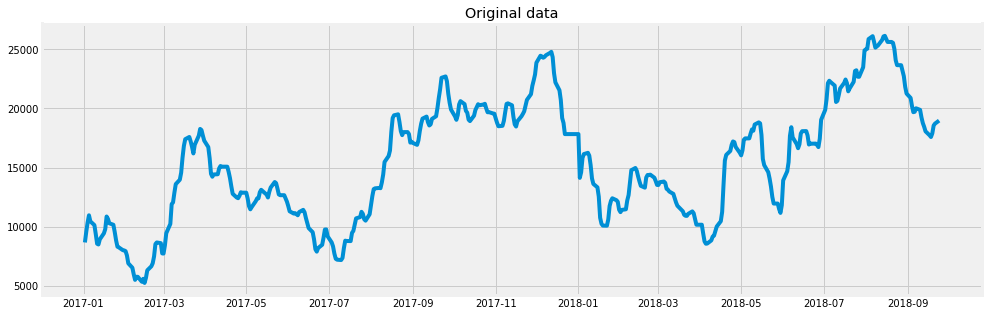

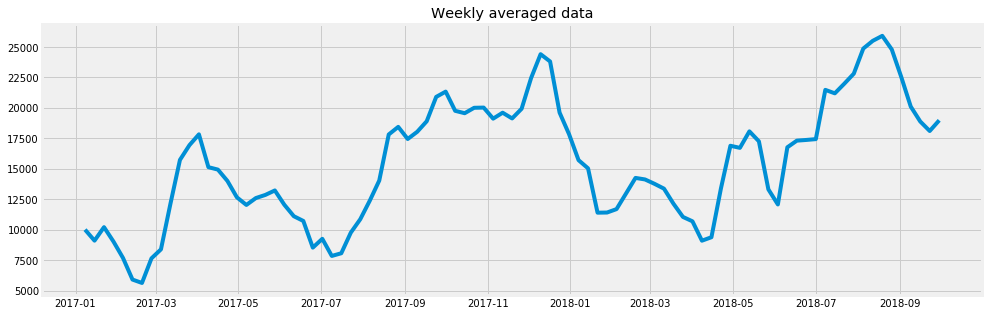

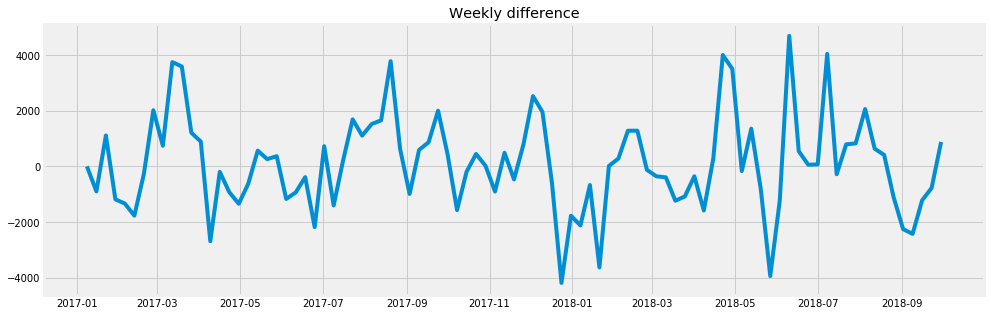

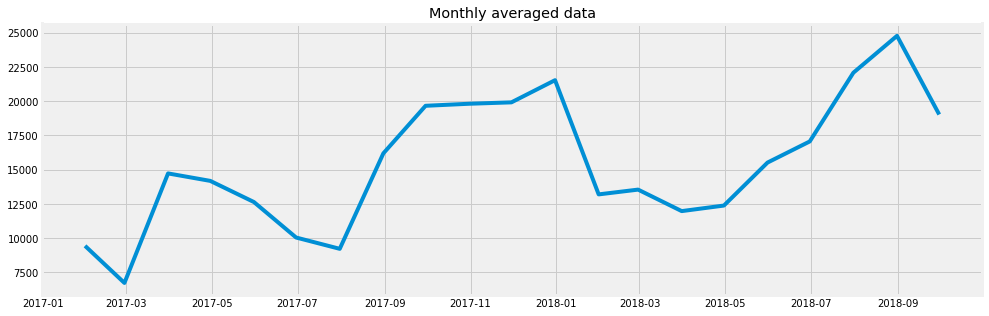

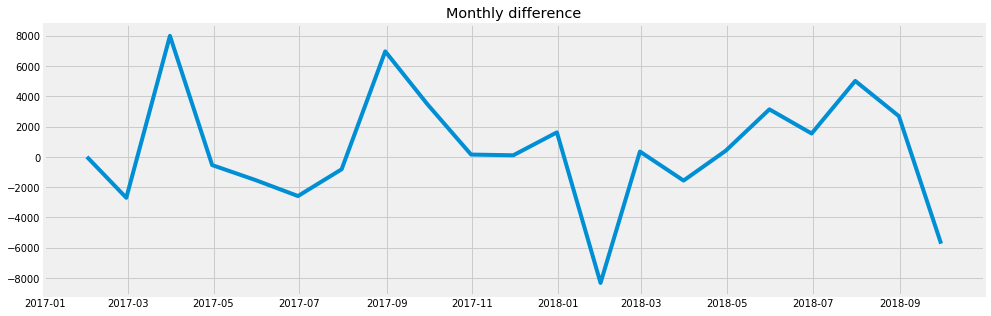

In [2]:
# Weekly average (5 days per week) and difference
weekly = data.resample('W',convention='start').mean()
week_diff = shipping_difference(weekly)
week_diff.dropna(inplace=True)

# Monthly average and difference
monthly = data.resample('M',convention='start').mean()
month_diff = shipping_difference(monthly)
month_diff.dropna(inplace=True)

# Set figure size
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(data)
plt.title('Original data')
plt.show()

plt.plot(weekly)
plt.title('Weekly averaged data')
plt.show()

plt.plot(week_diff)
plt.title('Weekly difference')
plt.show()

plt.plot(monthly)
plt.title('Monthly averaged data')
plt.show()

plt.plot(month_diff)
plt.title('Monthly difference')
plt.show()

We can see our original data in the plots above, as well as the weekly average, the weekly difference, the monthly average and the monthly difference.<br> 
Although the original data is not stationary, it can be seen that just by taking the difference--which is what we want to forecast--even a first order difference seems to stationarise the data, though this has to be checked with an ADF test.

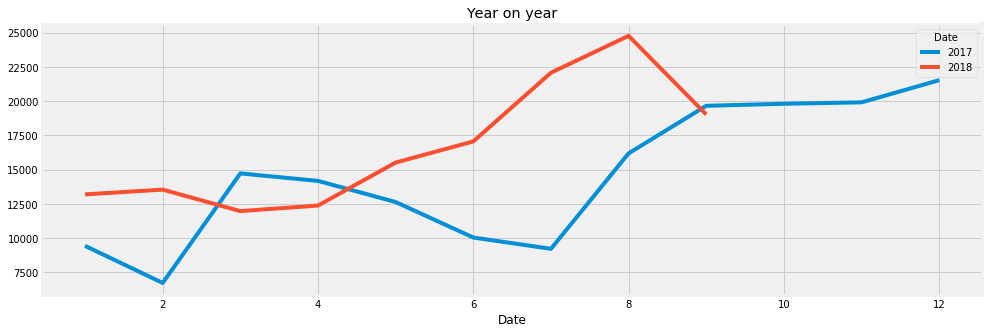

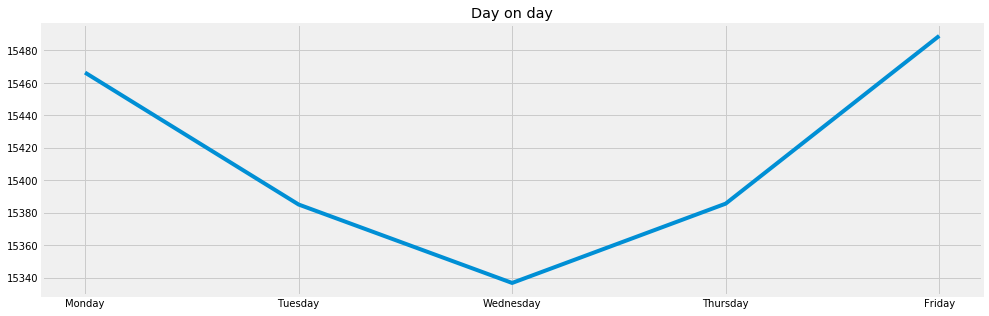

In [3]:
# Monthly averaged, year on year plot to look for any yearly trend
df = pd.DataFrame(data)
pv = pd.pivot_table(df, index=df.index.month, columns=df.index.year,
                    values='Shipping Cost ($)', aggfunc='mean')
ax1 = pv.plot(title='Year on year')
plt.show()

# Weekday seasonality
df['my_date'] = pd.to_datetime(df.index)
df['weekday'] = df.my_date.dt.weekday_name
dy = pd.pivot_table(df, index=df.weekday,
                    values='Shipping Cost ($)', aggfunc='mean')
dy['DAY_OF_WEEK'] = pd.Categorical(dy.index, 
  categories=['Monday','Tuesday','Wednesday','Thursday','Friday'], ordered=True)
dy.index = dy.DAY_OF_WEEK
dy = dy.sort_index()
dy.drop('DAY_OF_WEEK',axis=1, inplace=True)
ax2 = plt.plot(list(dy.index), dy['Shipping Cost ($)'])
plt.title('Day on day')
plt.show()

Here we can see there is a definite weekly seasonality, with Wednesday shipping cost being the lowest and an almost symmetrical distribution where both the start and end of the week are much more expensive to ship. <br>
Additionally, by comparing the year-on-year data, can see there is an upward trend for both years but there is little obvious similarity between the two years in terms of shipping costs aggregated on a monthly basis.

In [4]:
# Conducting ADF test on 1st-order differenced data
day_diff = shipping_difference(data)
day_diff.dropna(inplace=True)
adfullertest(day_diff)

ADF Statistic: -11.184554
p-value: 0.000000
Critical Values:
	10%: -2.570
	1%: -3.445
	5%: -2.868


We can see that our p-value is <<< 0.05 and our ADF statistic is far lower than what we would require for a 1% confidence interval of stationarity, thus we can be quite sure the data is stationary once taking a first order difference.

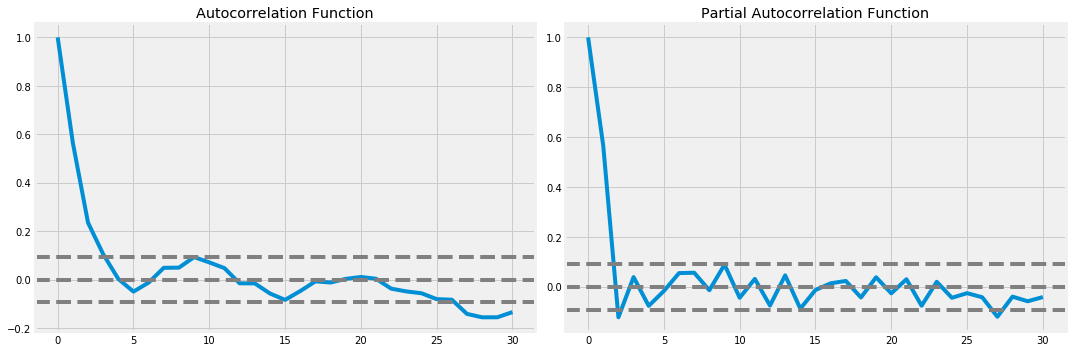

In [5]:
# Plotting ACF and PACF
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(day_diff, nlags=30)
lag_pacf = pacf(day_diff, nlags=30, method='ols')

# Plot ACF of weekly difference 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(day_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(day_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Plot PACF of weekly difference
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(day_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(day_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The following observations can hence be made from the initial exploration:<br><br>
•	The data appeared to have a yearly seasonality, but from the data available (1.75 years) it is impossible to know how consistent this seasonality is. Ideally, we would have at least 3 years of data so that we could investigate the trend and seasonality better;<br>
•	The data had a weekly seasonality, where the shipping cost was highest in the middle of the week and reduced at both beginning and end;<br>
•	The data was significantly stationary when differenced, with a 99.9% confidence from performing an ADF test;<br>
•	The data to be forecast (difference in weekly average and difference in monthly average) was highly volatile and exhibited extremely large variance.<br> <br>
The ACF and PACF plots and their decay prior to the 2nd lag indicated that there may be benefit in fitting autoregressive and moving average models to the data, but the decay is not continuous and appears to oscillate steadily so this would have to be further investigated. <br>

# Modelling Strategy 

Due to the fact that the time series we want to forecast (weekly and monthly difference in shipping cost) is highly volatile, we must think carefully about how we will approach this problem. Particularly for univariate time series problems, Spyros Makridakis et. al (2018) showed that classical techniques still heavily outperform machine learning techniques, particularly in multi-step forecasting which is our goal here. <br> <br>
We will then do some quick initial modelling with Prophet to see how an additive regression model performs for such a volatile time series. We also will use this as an opportunity to see if predicting the original time series (i.e. daily data) and then aggregating and taking the difference will give comparable results to attempting to forecast on the weekly and monthly difference time series. <br> <br>
We will also develop a quick naive forecast to use as our baseline performance and to which we can compare our Prophet model. The main reason for not doing this immediately is that we need to investigate whether we can obtain a forecasting model for our daily data, and then simple take the averages and differences to obtain our desired weekly and monthly forecast, or if we need to individually work with the monthly and weekly difference datasets and create two individual forecasts. <br> <br>
S/ARIMA will then be investigated to see whether this common classical technique accurately models the data.<br> <br>
Finally, a LSTM model will be trained as although ML techniques are not as powerful on univariate time series, LSTM models are common and thought generally to perform well, so this will be also investigated. <br> <br> 

Although usually a train/test split of approximately 70%/30% is used, as we are attempting to forecast up to 3 months of data, we will use only the last three months as test data.

# Initial Modelling with Prophet


As Python does not have built-in capability to include dummy variables into SARIMA models or a robust TBATS model implementation, constructing an ARIMA and manually incorporating Fourier terms is not a time-efficient approach in order to obtain a first-pass at a forecast. As such, the open-source package Prophet was used in Python as an initial model for three main reasons:<br><br>
	•	Multiple seasonal patterns could be included, such as yearly as well as monthly, in addition to seasonal effects caused by human behaviour;<br>
	•	The model can easily be switched between using multiplicative and additive seasonality;<br>
	•	SARIMA cannot handle large seasonality periods, such as 52 periods per year when modelling with weekly data;<br>
	•	The model is expressly designed for high-frequency business data, particularly daily or weekly data.<br><br>

Prophet is, however, disadvantaged in that it performs best with high-frequency data, so this poses a problem for our monthly difference in shipping cost forecast requirement. <br> <br>
Prophet uses an additive regression model, described by:<br>
y(t)=g(t)+s(t)+h(t)+e_i<br>
Where g(t) represents trend and models non-periodic changes, s(t) represents seasonality and models periodic changes and h(t) models holiday components.<br>
In brief summary, the model was constructed as follows:<br><br>
	•	The data was split into training data and testing data, the latter of which comprised the last 3 months of the dataset (July, August and September 2018) as the problem aim is to perform a 3-month multi-step forecast;<br>
	•	A Yeo-Johnson power transform was performed on the data to normalise the dataset; and<br>
	•	The Prophet model was fitted with yearly and monthly seasonality was incorporated via Fourier terms (yearly seasonality of period 52.18, Fourier order 10 and monthly seasonality of period 30.5 and Fourier order 8).<br>


In [6]:
import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

# Comparison dataframe to calculate errors (MAPE, MAE)
def make_comparison_dataframe(historical, forecast):
    """
    Join the history with the forecast.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

# Function to calculat MAPE and MAE for Prophet models 
def calculate_forecast_errors(df, prediction_size):
    """
    Calculate MAPE and MAE of the forecast.
    
    Args:
       df: joined dataset with 'y' and 'yhat' columns.
       prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

## Modelling weekly and monthly data
We will first try forecasting the weekly difference and monthly difference data

In [7]:
# Train/test split (last 3 months is test set)
weekly = week_diff
train_data = weekly.loc[:'2018-06-24']
test_data = weekly.loc['2018-07-01':]

# Set up for Prophet
df = pd.DataFrame(train_data)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']

all_history = pd.DataFrame(weekly)
all_history.reset_index(inplace=True)
all_history.columns = ['ds', 'y']

In [8]:
# Including Australian holidays into our model (not significant for weekly/monthly but may be significant for daily)
aushols = pd.read_csv('C:/Users/kalin/EOI/australianpublicholidays-201718.csv')
aushols = aushols.loc[(aushols['Applicable To']=='ACT|NSW|NT|QLD|TAS|VIC|WA')\
                       | (aushols['Applicable To'].str.contains('NAT'))]
aushols.drop(['Information', 'More Information', 'Applicable To'], axis=1, inplace=True)
aushols['Date'] = pd.to_datetime(aushols.Date, yearfirst=True,infer_datetime_format=True,format="%Y%m%d")
aushols.columns = ['ds', 'holiday']

Difference in weekly average forecast error metrics: 

MAPE 177.81410307492925
MAE 1097.5191816827487

RMSE between overall fitted model and data: 
1273.675519669302


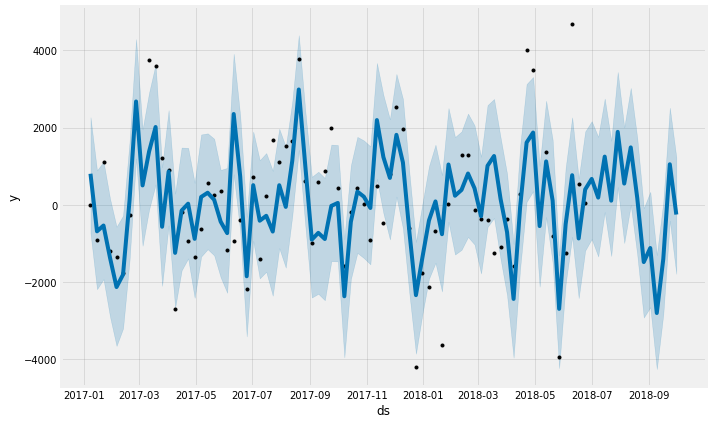

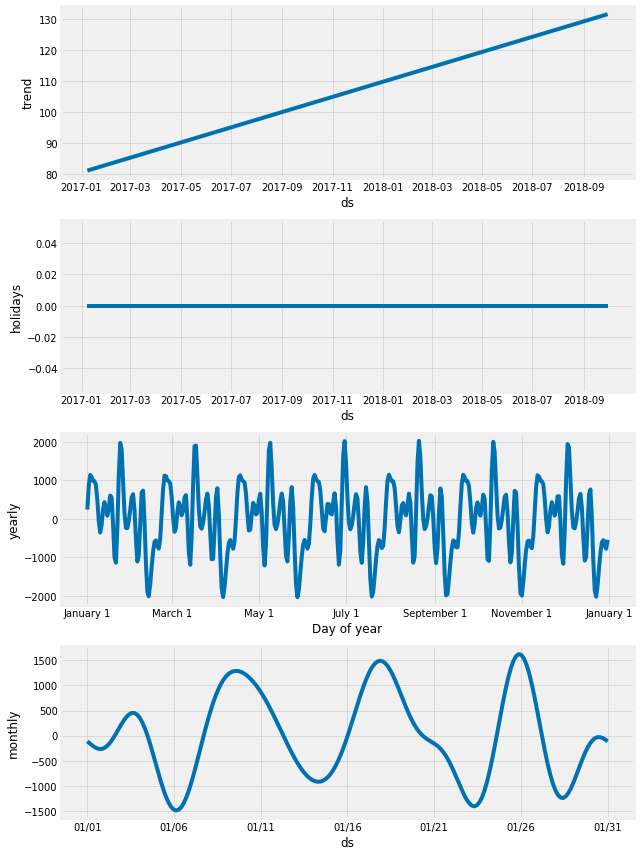

In [9]:
# Create forecast model and add seasonality with appropriate Fourier terms. Daily seasonality false since modelling weekly
m = Prophet(weekly_seasonality=False, daily_seasonality=False, holidays=aushols, yearly_seasonality=False)
m.add_seasonality(name='yearly', period=52.18, fourier_order=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=8)
# Fit to data
m.fit(df)
# Predict onto our dataframe that only had weekdays as otherwise we will erroneously include weekends
future = pd.DataFrame(all_history.ds)
forecast = m.predict(future)

#Plotting forecast and components
m.plot(forecast)
m.plot_components(forecast)

# Comparison dataframe to obtain error metrics
cmp_df = make_comparison_dataframe(all_history, forecast)
cmp_df.dropna(inplace=True)

print('Difference in weekly average forecast error metrics: \n')
for err_name, err_value in (
        calculate_forecast_errors(cmp_df, len(test_data)).items()
        ):

    print(err_name, err_value)
    
print('\nRMSE between overall fitted model and data: ')
print(np.sqrt(mean_squared_error(all_history.y.values, forecast.yhat.values)))

# For later plotting
history_w = all_history.copy()
model_fit_w = forecast.iloc[:77]
pure_forecast_w = forecast.iloc[76:]

Difference in monthly average forecast error metrics: 

MAPE 118.03958857124286
MAE 5465.3806542759385

RMSE between overall fitted model and data: 
3098.293549638226


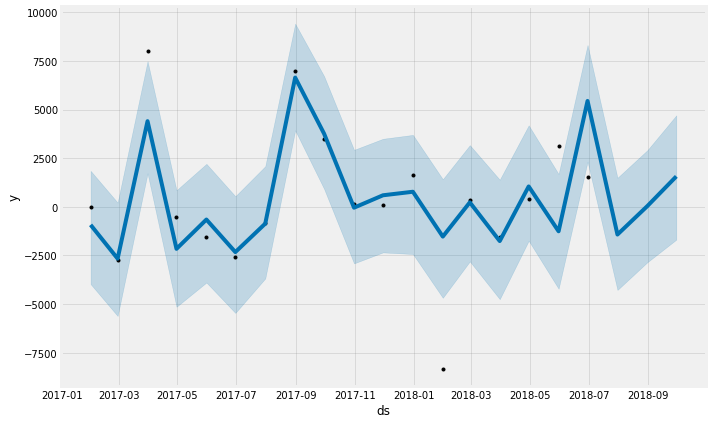

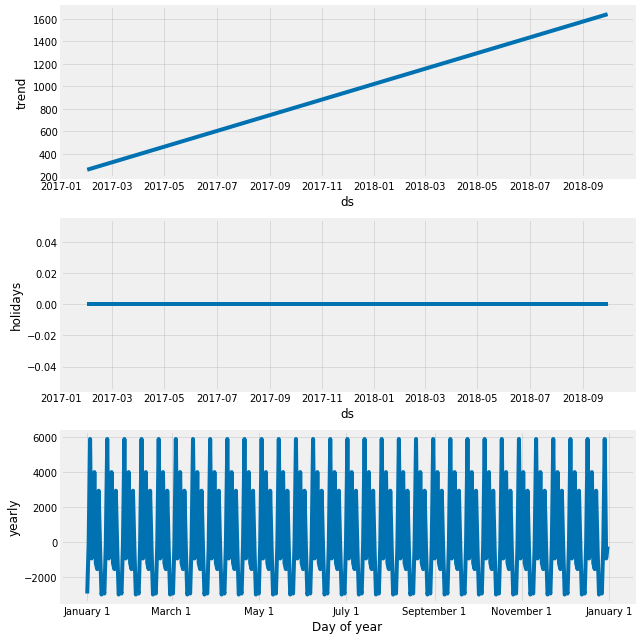

In [10]:
# Suppressing deprecation warnings etc
warnings.simplefilter('ignore')
import logging
logging.getLogger("fbprophet.forecaster").setLevel(logging.WARNING)

# Looking at monthly forecast (same procedure as above)
monthly = data.resample('M',convention='start').mean()
month_diff = shipping_difference(monthly)
month_diff.dropna(inplace=True)

monthly = month_diff
train_data = monthly.loc[:'2018-06-30']
test_data = monthly.loc['2018-07-31':]

df = pd.DataFrame(train_data)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']

all_history = pd.DataFrame(monthly)
all_history.reset_index(inplace=True)
all_history.columns = ['ds', 'y']

m_month = Prophet(weekly_seasonality=False, holidays=aushols, yearly_seasonality=False, daily_seasonality=False)
m_month.add_seasonality(name='yearly', period=12, fourier_order=10)
m_month.fit(df)
future = pd.DataFrame(all_history.ds)
forecast = m_month.predict(future)
m_month.plot(forecast)
m_month.plot_components(forecast)

cmp_df = make_comparison_dataframe(all_history, forecast)
# Predicting for saturday and sunday as well (drop)
cmp_df.dropna(inplace=True)

print('Difference in monthly average forecast error metrics: \n')
for err_name, err_value in (
        calculate_forecast_errors(cmp_df, len(test_data)).items()
        ):
    print(err_name, err_value)

print('\nRMSE between overall fitted model and data: ')
print(np.sqrt(mean_squared_error(all_history.y.values, forecast.yhat.values)))

# For later plotting
history_m = all_history.copy()
model_fit_m = forecast.iloc[:18]
pure_forecast_m = forecast.iloc[17:]

As can be seen above, the weekly difference forecast provides a reasonable forecast and quite closely follows the general trend of the actual data. For the monthly case, however, Prophet performs quite poorly but this is not surprising when we only have 21 data points and this is all the model can train from. It is expected that for any technique--classical or ML--training a model on 18 points will most likely be extremely inaccurate. If we observe the year-on-year plot, if there was some sort of obvious seasonality (i.e. a very similar trend repeated itself annually) then incorporating this--as we have done above--would yield more accurate results. However, there is no detectable trend for the monthly case and the weekly forecast is most likely as accurate as it is only due to the fact there are smaller seasonal clusters within the data, which the model can pick up on. Forecasting at this resolution appears reasonable for Prophet. <br> <br>
Based on this alone, it is likely we will have to forecast the original data and then compute the weekly and monthly differences. This however introduces further issues as we are no longer dealing with a stationary series, but we will first look at Prophet's performance in the case where we fit a model to the original, daily data and then compute the monthly and weekly differences there.<br> <br>
For the sake of conciseness, the creation of the model for the daily and subsequent transformation to monthly/weekly difference in averages is not included but the final RMSE, MAE and MAPE values are included in tabular format below. In addition, the weekly difference model was also normalised by using a Power transform (Yeo-Johnson, as we have negative and non-negative values) to see if this would improve the fit. The power-transformed results are also shown below. <br> <br>
We also created a naive forecast to compare the RMSE values, which are also included in the table below.

MAPE 171.39565025306482
MAE 1136.4272991636808

RMSE between overall fitted model and data: 
1279.6161884886596


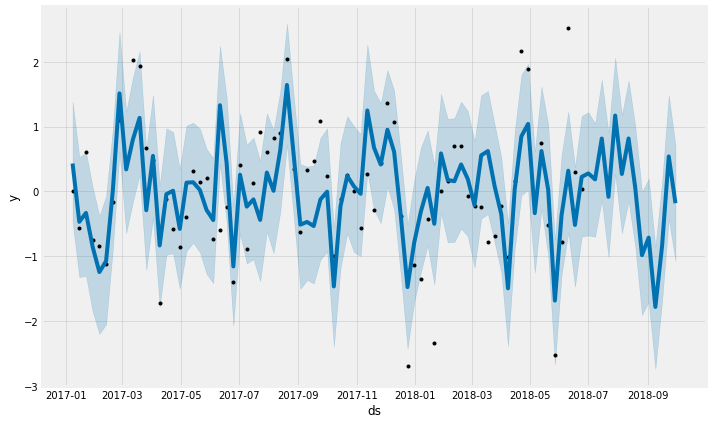

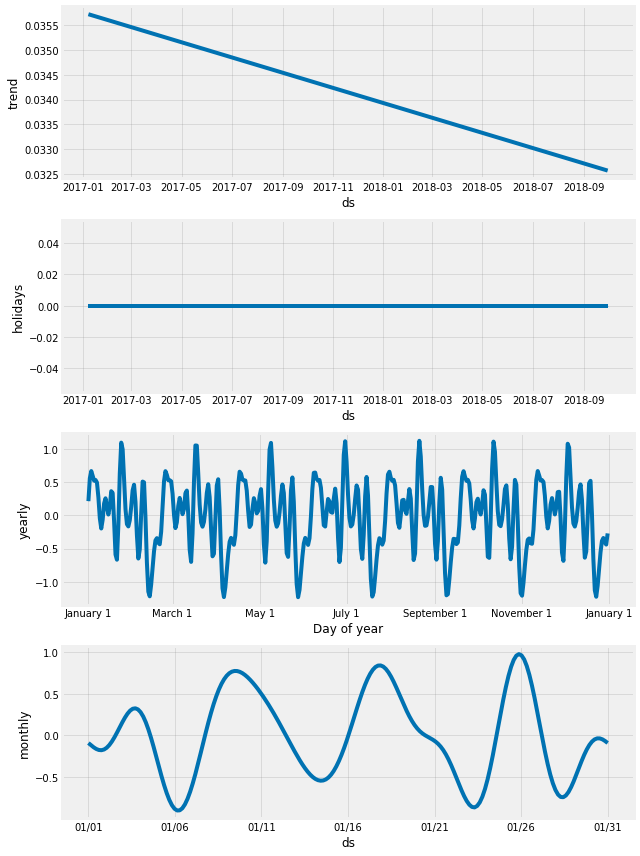

In [11]:
"""Yeo-Johnson Transform"""
from sklearn.preprocessing import PowerTransformer

train_data = weekly.loc[:'2018-06-24']
test_data = weekly.loc['2018-07-01':]

df = pd.DataFrame(train_data)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']

all_history = pd.DataFrame(weekly)
all_history.reset_index(inplace=True)
all_history.columns = ['ds', 'y']

pt = PowerTransformer()
train_df2 = df.copy().set_index('ds')
pt.fit(train_df2)
df2 = pt.transform(train_df2)
df = pd.DataFrame(df2, index=train_df2.index, columns=['y'])
df['ds'] = df.index

m = Prophet(weekly_seasonality=False, holidays=aushols, yearly_seasonality=False)
m.add_seasonality(name='yearly', period=52.18, fourier_order=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=8)
m.fit(df)
#future = m.make_future_dataframe(periods=len(test_data))
# Hard code to have weekly intervals
future = pd.DataFrame(all_history.ds)
forecast = m.predict(future)
m.plot(forecast)
m.plot_components(forecast)

# Revert transform
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[column] = pd.DataFrame(pt.inverse_transform(np.array(forecast[column]).reshape(-1,1)))[0]

cmp_df = make_comparison_dataframe(all_history, forecast)
# Predicting for saturday and sunday as well (drop)
cmp_df.dropna(inplace=True)

for err_name, err_value in (
        calculate_forecast_errors(cmp_df, len(test_data)).items()
        ):
    print(err_name, err_value)

print('\nRMSE between overall fitted model and data: ')
print(np.sqrt(mean_squared_error(all_history.y.values, forecast.yhat.values)))

In [12]:
""" Naive forecast """

def model_persistence(x):
    """ Persistence model"""
    return x

def naive_forecast(time_ser, len_test):
    """
    Computes naive forecast and returns RMSE score.
    Inputs: 
        time_ser (pd.Series), time series to forecast
        len_test (int), length of test data
    Outputs:
        RMSE (float), RMSE score of naive forecast
    """
    # Create lagged dataset
    values = time_ser.values
    df = pd.concat([pd.Series(np.roll(values,1)[1:]), pd.Series(values[1:])],
                   axis=1)
    df.columns = ['t-1','t']
    
    # Split into train/test sets
    X = df.values
    train, test = X[:len_test], X[len_test:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]
    
    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = model_persistence(x)
        predictions.append(yhat)
    test_score = np.sqrt(mean_squared_error(test_y, predictions))
    
    return print('Test RMSE: %.3f' % test_score)

In [13]:
print('Naive forecast for weekly difference:')
naive_forecast(week_diff, 77)   
print('\nNaive forecast for monthly difference:')
naive_forecast(month_diff, 18)

Naive forecast for weekly difference:
Test RMSE: 1909.117

Naive forecast for monthly difference:
Test RMSE: 6185.076


In [14]:
from IPython.display import display

table_dict = [{'MAE':1097.519, 'MAPE':177.814, 'RMSE':1273.675},
              {'MAE':1136.427, 'MAPE':171.396, 'RMSE':1279.616},
              {'MAE':1831.060, 'MAPE':297.014, 'RMSE':1556.565},
              {'MAE':5465.381, 'MAPE':118.040, 'RMSE':3098.294},
              {'MAE':6324.338, 'MAPE':170.304, 'RMSE':3504.342},
              {'RMSE':1909.117},
              {'RMSE':6185.076}]

table = pd.DataFrame(table_dict)
table_t = table.transpose()
table_t.columns = ['Week diff', 'Week diff w/ transform', 'Daily to week diff', 'Month diff', 'Daily to month diff',
                   'Naive week', 'Naive month']
table_t

,Week diff,Week diff w/ transform,Daily to week diff,Month diff,Daily to month diff,Naive week,Naive month
MAE,1097.519,1136.427,1831.060,5465.381,6324.338,NaN,NaN
MAPE,177.814,171.396,297.014,118.040,170.304,NaN,NaN
RMSE,1273.675,1279.616,1556.565,3098.294,3504.342,1909.117,6185.076


From the above, we can summarise the following: <br> <br>
•	Weekly difference in price average is by far best predicted when forecast on the difference in weekly average data, as opposed to forecasting on the original data and then taking the average and difference. The same is true for the monthly case, where immediately averaging and differencing the data improves the RMSE score from 3504 to 3098 instead of transforming the forecast;<br>
•	Surprisingly, all models perform better than the baseline naive forecast;<br>
•	Incorporating a power transform does little to improve the model, only marginally improving MAPE but decreasing MAE and RMSE; and<br> 
•	Predicting the monthly difference with only an entire dataset of 21 points (and when testing, 18) with very little obvious seasonality leads to poor results and very large errors. <br> <br>
Finally, we will have a look at our actual forecasted model versus our fitted data, visually. 

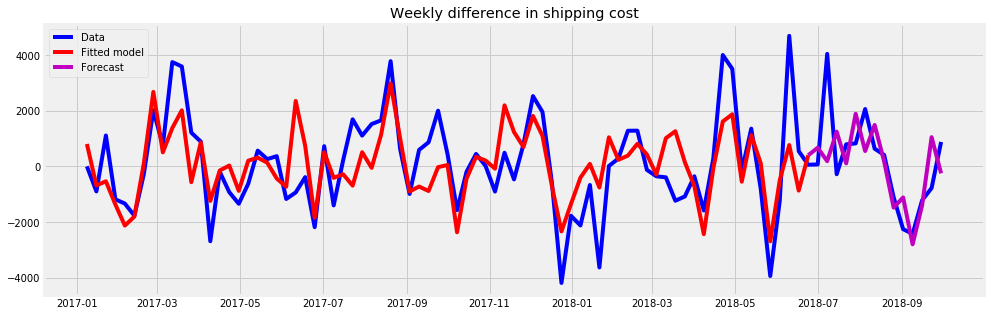

In [15]:
history_w.index = history_w.ds
model_fit_w.index = model_fit_w.ds
pure_forecast_w.index = pure_forecast_w.ds

plt.plot(history_w.y, 'b', label = 'Data')
plt.plot(model_fit_w.yhat, 'r', label = 'Fitted model')
plt.plot(pure_forecast_w.yhat, 'm', label = 'Forecast')
plt.legend(loc='upper left')
plt.title('Weekly difference in shipping cost')
plt.show()

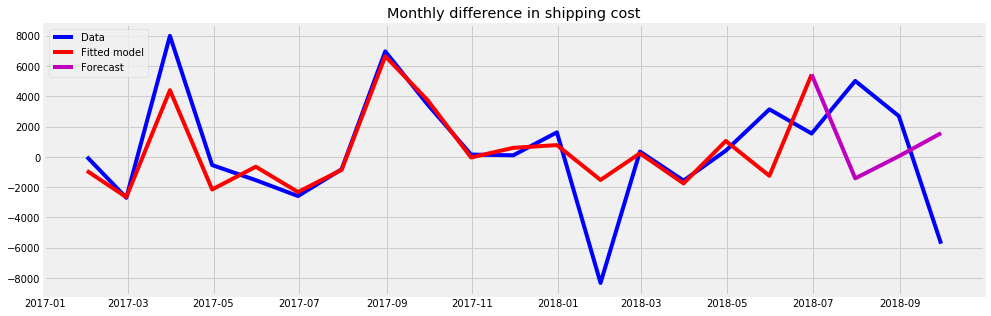

In [16]:
history_m.index = history_m.ds
model_fit_m.index = model_fit_m.ds
pure_forecast_m.index = pure_forecast_m.ds

plt.plot(history_m.y, 'b', label = 'Data')
plt.plot(model_fit_m.yhat, 'r', label = 'Fitted model')
plt.plot(pure_forecast_m.yhat, 'm', label = 'Forecast')
plt.legend(loc='upper left')
plt.title('Monthly difference in shipping cost')
plt.show()

Based on the initial modelling we did in Prophet, we proceeded with to investigate a SARIMA based on the following key findings:<br>
1.	We assumed that the most precise model is obtained by forecasting on the weekly difference in price average and monthly difference in price average, as opposed to forecasting on the original daily data and then averaging and taking differences. Although we did not know this is the case for all other models, we make this assumption based on our Prophet model and in the interest of time constraints; and<br><br>
2.	We focused primarily on forecasting the weekly difference in price average, as the monthly case only has a test dataset of 18 and unlikely to be forecasted accurately. We still forecast on a monthly level; however, we did not focus on this as an indicator of the model’s performance. 


# SARIMA Model

A SARIMA model was also constructed to forecast both weekly difference in shipping cost and monthly difference in shipping cost. The primary disadvantage of this model was that it cannot handle large seasonal periods—although there is a large yearly seasonal component to the data, SARIMA cannot reasonably incorporate a 52-period season when modelling with weekly average. <br>Additionally, the data is highly volatile with significant variance, which is also difficult for a model such as SARIMA. Ideally, a SARIMA-GARCH model could be used where GARCH is layered upon the SARIMA model by modelling volatility (and hence the variance) in the residuals after trend and seasonality has already been accounted for by SARIMA. However, due to time constraints, only a basic SARIMA model is created.
The SARIMA(p,d,q)x(P,D,Q)m parameters were required to be chosen.
The model was constructed as follows:
1.	First-order difference taken and the resulting data checked for stationarity using the Augmented Dickey-Fuller test, which was confirmed with a P-value of <0.00001. This was performed during our initial data exploration, but 
2.	Seasonal decomposition was performed on the data, although the only detectable seasonality was weekly seasonality and thus none a
3.	Second-order difference taken to investigate ACF and PACF plots to determine lag values as we are modelling the difference in cost, not the cost level itself. This was also used to check for seasonality.
4.	A basic grid-search was performed to optimise for the (p,d,q) parameters in case the ACF and PACF plots did not give an accurate indication.
5.	A Box-cox transformation was used on the data and the SARIMA model was fitted.


In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

We firstly wanted to re-examine our ACF and PACF plots so that we could estimate our p and q parameters. It would be expected that our d parameter should be 0 as we are working with the difference in weekly average, which our ADF test showed to be stationary (and is confirmed visually). We replot the ACF and PACF plots below.

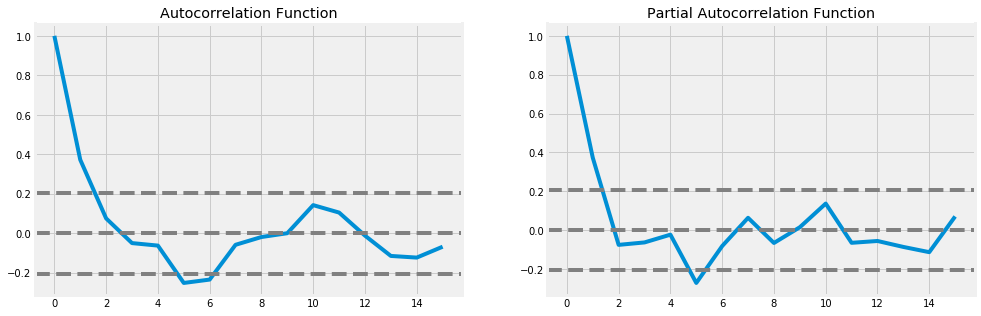

In [18]:
lag_acf = acf(week_diff, nlags=15)
lag_pacf = pacf(week_diff, nlags=15, method='ols')

# Plot ACF of weekly difference (as we need stationary data)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(week_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(week_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF of weekly difference (as we need stationary data)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(week_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(week_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.show()

We can see that both the ACF and PACF plots cross the upper confidence interval before the second lag value (lag value of 2). So for our ARIMA model, we can see that our (p,d,q) parameters should initially be set at (2,1,2)--the 1 is required as we have taken one difference in order to stationarise the model, so a first order difference is also required. Our ACF plot tells us what sort of moving average lag we need (q=2) and our PACF tells us what sort of auto-regression lag we need (p=2). <br> <br>
We will try using an ARIMA(2,1,2) model and inspect the initial results (can then try (1,1,1) and incorporate seasonality as well if we find it does not perform as expected). <br>
However, we do not expect the S/ARIMA model to fit very well as the PACF is not decaying as expected, although the ACF decays quite reasonably. It is likely that including auto-regression lag terms will not be statistically significant.

In [19]:
# Need to split data into training and test set
train = week_diff.loc[:'2018-06-24']
test = week_diff.loc['2018-07-01':]

In [20]:
# Preliminary ARIMA model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

model_212 = ARIMA(train, order=(2,1,2))
model_212_fit = model_212.fit(disp=False, maxiter=500)
print(model_212_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Difference   No. Observations:                   76
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -668.867
Method:                       css-mle   S.D. of innovations           1551.771
Date:                Thu, 07 Feb 2019   AIC                           1349.734
Time:                        19:31:26   BIC                           1363.718
Sample:                    01-15-2017   HQIC                          1355.322
                         - 06-24-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.1447     12.715     -0.090      0.929     -26.065      23.776
ar.L1.D.Difference    -0.5359      0.111     -4.813      0.000      -0.754      -0.318
ar.L2.D.Difference  

We can see that the model does not appear to be an ideal fit and the second auto-regression term is not significant, although our moving average terms are and so is the first AR term. Keeping this in mind, we will have a look at our residuals and check whether they are Gaussian distributed.

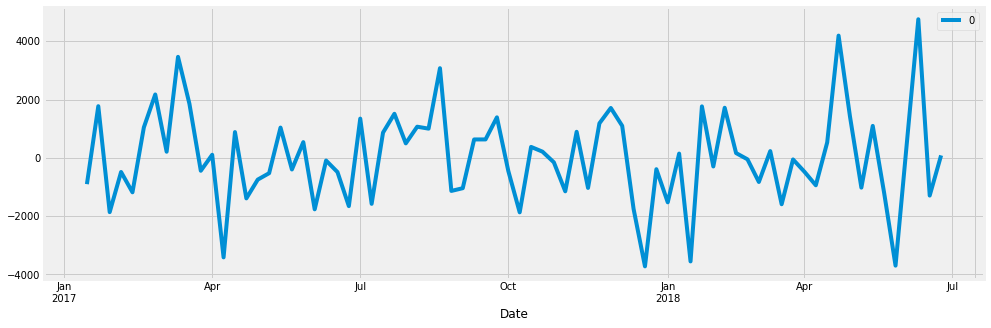

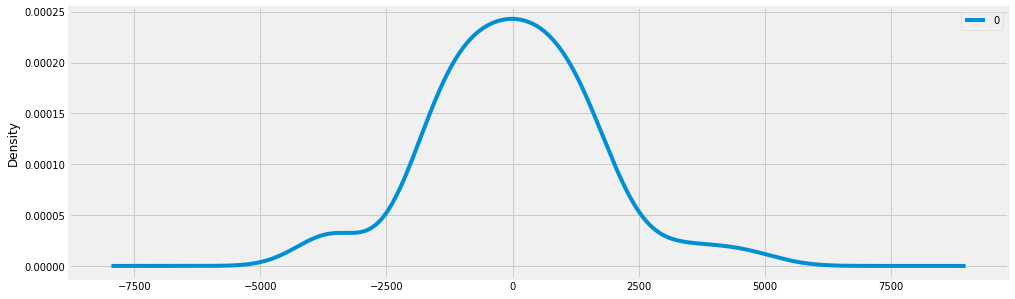

                 0
count    76.000000
mean     13.584485
std    1610.706100
min   -3720.748700
25%   -1033.526149
50%      16.606957
75%    1039.443502
max    4751.878944


In [21]:
# Plotting our residuals
residuals = pd.DataFrame(model_212_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

We can see that we have a Gaussian-shaped distribution, albeit transformed. The mean is not quite 0 and thus implies some bias as it is sitting at 13.58, and the curve itself is wide with an asymmetrical shape but no obvious tails. We can attempt to check whether there is some sort of seasonality (aside from the weekly pattern, which we have accounted for by taking the weekly average) and see whether we can improve our ARIMA model any more so that we can at least use it as a benchmark for other techniques. <br>
Since we have 52 weeks in a year and there appeared to be a yearly seasonality in our data, we anticipated that this would return the best (lowest) AIC score. However, SARIMA is not very capable of handling so many periods in one season so this had to be investigated to see whether sensible results were obtained. Values from 2 seasons up to 52 were cycled through to find which number of seasons led to the best AIC scores.

In [22]:
season = list(range(2,53))
seasonal_pdq = [(1,0,0,x) for x in season]

param = (2,1,2)
for pdq in seasonal_pdq:
    try:
        mod = SARIMAX(train, order=param, seasonal_order=pdq,enforce_stationarity=False, enforce_invertibility=False)
        
        results = mod.fit(disp=False, maxiter=500)
        
        print('ARIMA{}x{} - AIC:{}'.format(param, pdq, results.aic))
        
    except:
        continue


ARIMA(2, 1, 2)x(1, 0, 0, 2) - AIC:1282.1442757008858
ARIMA(2, 1, 2)x(1, 0, 0, 3) - AIC:1263.7511412902254
ARIMA(2, 1, 2)x(1, 0, 0, 4) - AIC:1248.3546085096614
ARIMA(2, 1, 2)x(1, 0, 0, 5) - AIC:1226.7849379798015
ARIMA(2, 1, 2)x(1, 0, 0, 6) - AIC:1212.212193562192
ARIMA(2, 1, 2)x(1, 0, 0, 7) - AIC:1194.0726440889111
ARIMA(2, 1, 2)x(1, 0, 0, 8) - AIC:1176.77758167291
ARIMA(2, 1, 2)x(1, 0, 0, 9) - AIC:1159.6249668389678
ARIMA(2, 1, 2)x(1, 0, 0, 10) - AIC:1139.1976349418542
ARIMA(2, 1, 2)x(1, 0, 0, 11) - AIC:1117.994830974819
ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:1104.0203372461347
ARIMA(2, 1, 2)x(1, 0, 0, 13) - AIC:1086.7042427927158
ARIMA(2, 1, 2)x(1, 0, 0, 14) - AIC:1066.8205587899006
ARIMA(2, 1, 2)x(1, 0, 0, 15) - AIC:1052.4152256078285
ARIMA(2, 1, 2)x(1, 0, 0, 16) - AIC:1036.267117617151
ARIMA(2, 1, 2)x(1, 0, 0, 17) - AIC:1018.5871576033832
ARIMA(2, 1, 2)x(1, 0, 0, 18) - AIC:1002.6883310681175
ARIMA(2, 1, 2)x(1, 0, 0, 19) - AIC:984.5909822734372
ARIMA(2, 1, 2)x(1, 0, 0, 20) - AIC:968.730

Unsurprisingly, the AIC values continue to decrease as the number of periods is increased due to an overfitting effect. Despite this, a 52-season period will be used as this makes the most sense contextually with our dataset, as there is a yearly seasonality component. <br><br>
Next, a grid search was performed in order to check our original (p,d,q) parameter estimation and see if this is indeed associated with the lowest AIC values. 

In [23]:
p = d = q = range(0, 3)
pdq_list = list(itertools.product(p, d, q))
period=52

for pdq in pdq_list:
    try: 
        mod1 = SARIMAX(train_data, order=pdq)
        mod2 = SARIMAX(train_data, order=pdq, seasonal_order=(1,0,0,period))
        
        results1 = mod1.fit(disp=False, maxiter=500)
        results2 = mod2.fit(disp=False, maxiter=500)
        
        print('ARIMA{} - AIC:{}'.format(pdq, results1.aic))
        print('SARIMA{}x{} - AIC:{} \n'.format(pdq, (1,0,0,10), results2.aic))
        
    except:
        continue

ARIMA(0, 0, 0) - AIC:1367.4140935580979
SARIMA(0, 0, 0)x(1, 0, 0, 10) - AIC:1367.2278534522375 

ARIMA(0, 0, 1) - AIC:1357.3046042244791
SARIMA(0, 0, 1)x(1, 0, 0, 10) - AIC:1357.741424741218 

ARIMA(0, 0, 2) - AIC:1359.1501802876473
SARIMA(0, 0, 2)x(1, 0, 0, 10) - AIC:1359.3309576865472 

ARIMA(0, 1, 0) - AIC:1367.4604251094727
SARIMA(0, 1, 0)x(1, 0, 0, 10) - AIC:1368.656967059852 

ARIMA(0, 1, 1) - AIC:1356.237321960602
SARIMA(0, 1, 1)x(1, 0, 0, 10) - AIC:1356.3701894458136 

ARIMA(0, 1, 2) - AIC:1345.951717951321
SARIMA(0, 1, 2)x(1, 0, 0, 10) - AIC:1346.4101843117462 

ARIMA(0, 2, 0) - AIC:1418.1141394031245
SARIMA(0, 2, 0)x(1, 0, 0, 10) - AIC:1419.1097769256316 

ARIMA(0, 2, 1) - AIC:1355.7516247698734
SARIMA(0, 2, 1)x(1, 0, 0, 10) - AIC:1357.0838958603408 

ARIMA(1, 0, 0) - AIC:1357.802737484219
SARIMA(1, 0, 0)x(1, 0, 0, 10) - AIC:1358.475853994536 

ARIMA(1, 0, 1) - AIC:1358.9884724285225
SARIMA(1, 0, 1)x(1, 0, 0, 10) - AIC:1359.5755704026521 

ARIMA(1, 1, 0) - AIC:1365.2052956906

It could be seen that the parameters (1,1,2)x(1,0,0,52) slightly outperformed our original estimation of (2,1,2) and hence this was chosen as our previous analysis also showed that the second AR term was not significant. Additionally, although there is little difference in incorporating seasonality, this was done to avoid a 'flat' forecast. From here, residuals were more closely examined and the forecast plotted.

                           Statespace Model Results                           
Dep. Variable:             Difference   No. Observations:                   77
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -650.044
Date:                Thu, 07 Feb 2019   AIC                           1308.088
Time:                        19:32:22   BIC                           1317.304
Sample:                    01-08-2017   HQIC                          1311.764
                         - 06-24-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8720      0.068     12.838      0.000       0.739       1.005
ma.L1         -0.5646      0.238     -2.374      0.018      -1.031      -0.098
ma.L2         -0.4333      0.130     -3.326      0.0

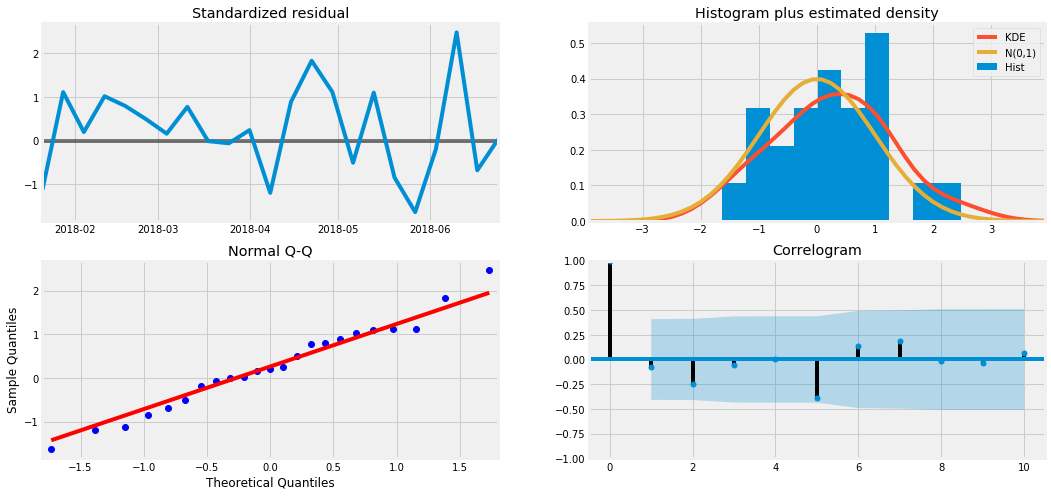

In [24]:
pdq = (1,1,2)
nonseason_mod = SARIMAX(train, order=(1,0,2),
              enforce_stationarity=False, enforce_invertibility=False)
mod = SARIMAX(train,order=pdq, seasonal_order=(1,0,0,52),
              enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit(disp=False, maxiter=500)
print(nonseason_mod.fit(disp=False, maxiter=500).summary())
results.plot_diagnostics(figsize=(16, 8))
plt.show()

This model clearly is not perfect but it tells us that our residuals are near normally distributed, which is a good sign. From here, we examined the actual forecast visually and also calculated the RMSE and MAE values to compare with our previous Prophet models.


RMSE between overall fitted model and data: 
1665.6722146070492

MAE for forecasted data only: 
1429.0111231565227


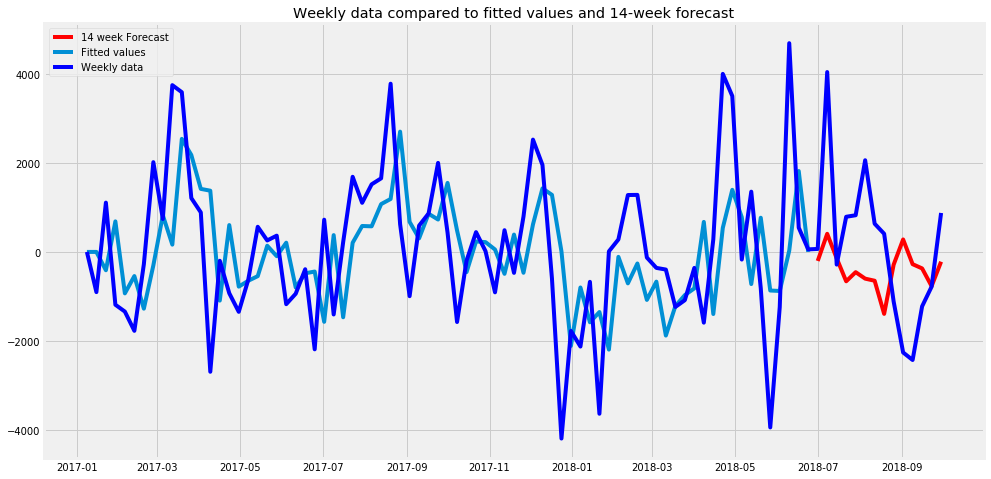

In [25]:
from sklearn.metrics import mean_absolute_error

# Try out forecast for 14 weeks
K = 14
forecast = results.forecast(K)
fitted_vals = results.fittedvalues

all_fit = fitted_vals.append(forecast)

print('\nRMSE between overall fitted model and data: ')
print(np.sqrt(mean_squared_error(week_diff.values, all_fit.values)))

print('\nMAE for forecasted data only: ')
print(mean_absolute_error(week_diff.iloc[-14:].values, forecast.values))


plt.figure(figsize=(15,8))
plt.plot(forecast, 'r', label='14 week Forecast')
plt.plot(fitted_vals, label='Fitted values')
plt.plot(week_diff, 'b', label='Weekly data')
plt.legend(loc='upper left')
plt.title('Weekly data compared to fitted values and 14-week forecast')
plt.show()

As can be seen in the forecast, the SARIMA model captures the fit of the data relatively well, though--as with Prophet--fails to achieve the variance in the data. The forecast also lacks this variance even more heavily and appears to be lagging behind. A greater order of moving average was not fitted, however, to avoid overfitting the data.<br>A similar process was followed for the monthly forecast, but the steps have not been repeated here for the sake of conciseness. The forecast is shown below alongside the diagnostics, and the RMSE score was found to be 6336.858 and the MAE score was found to be 3877.488.

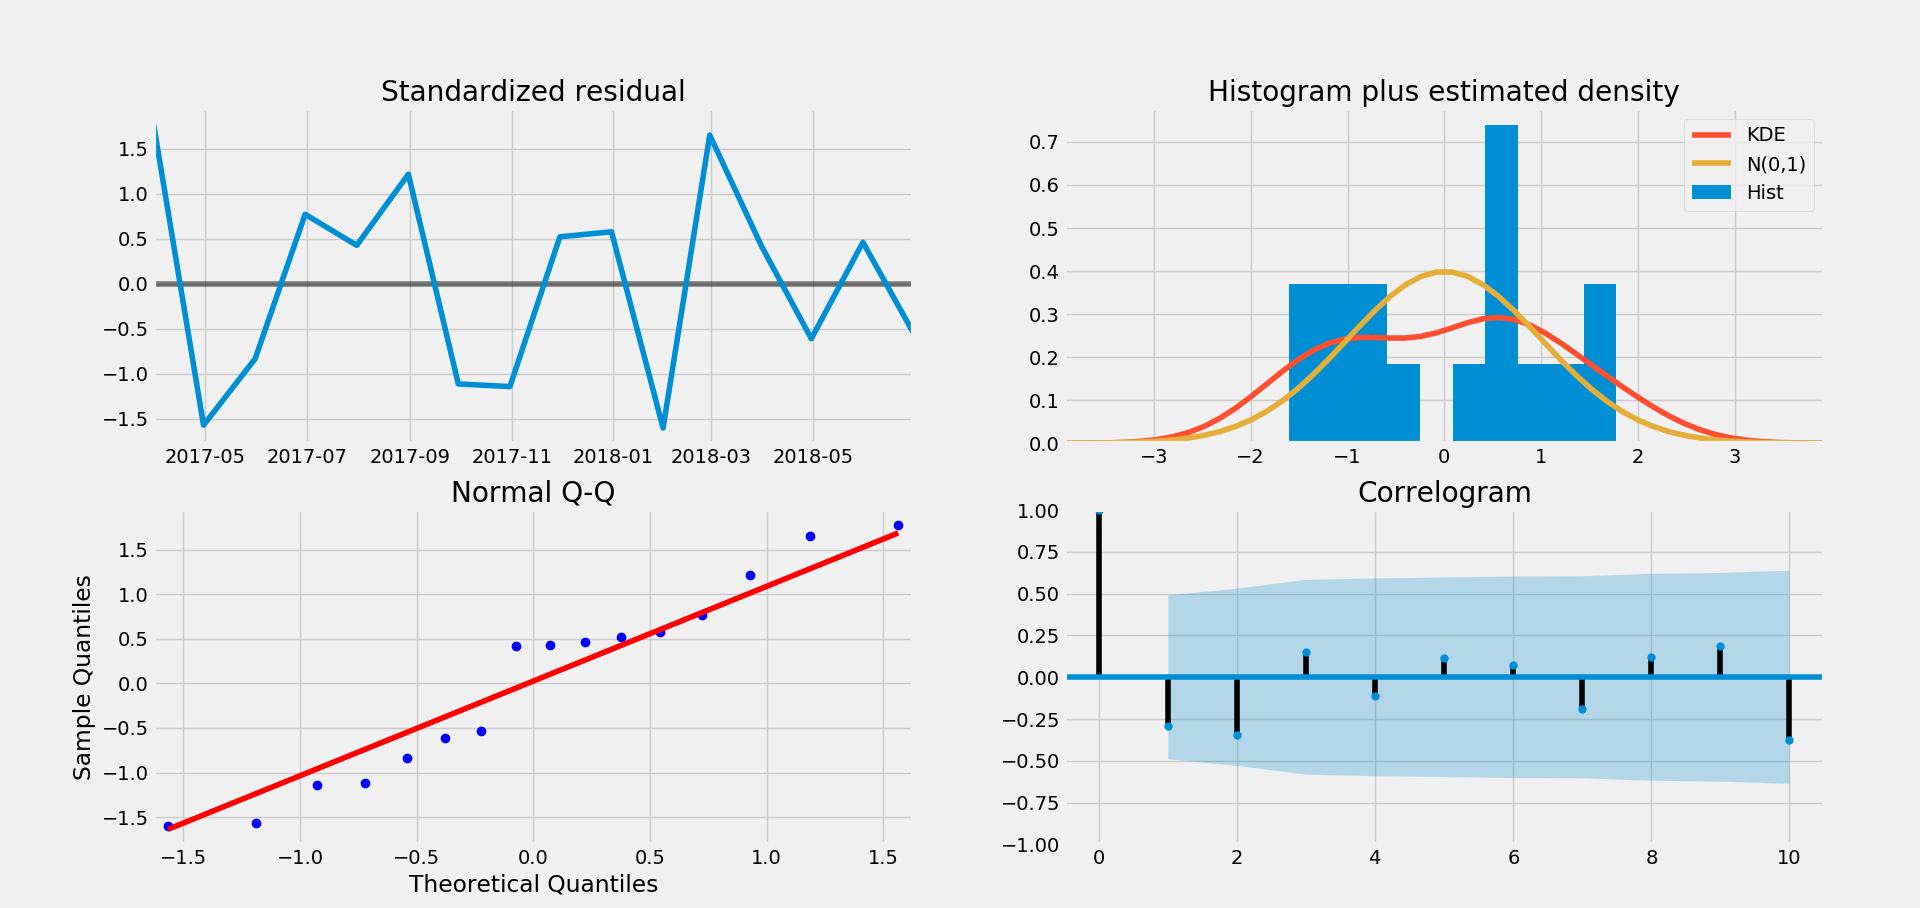

In [26]:
from IPython.display import Image
Image("images/3_month_diag.png")

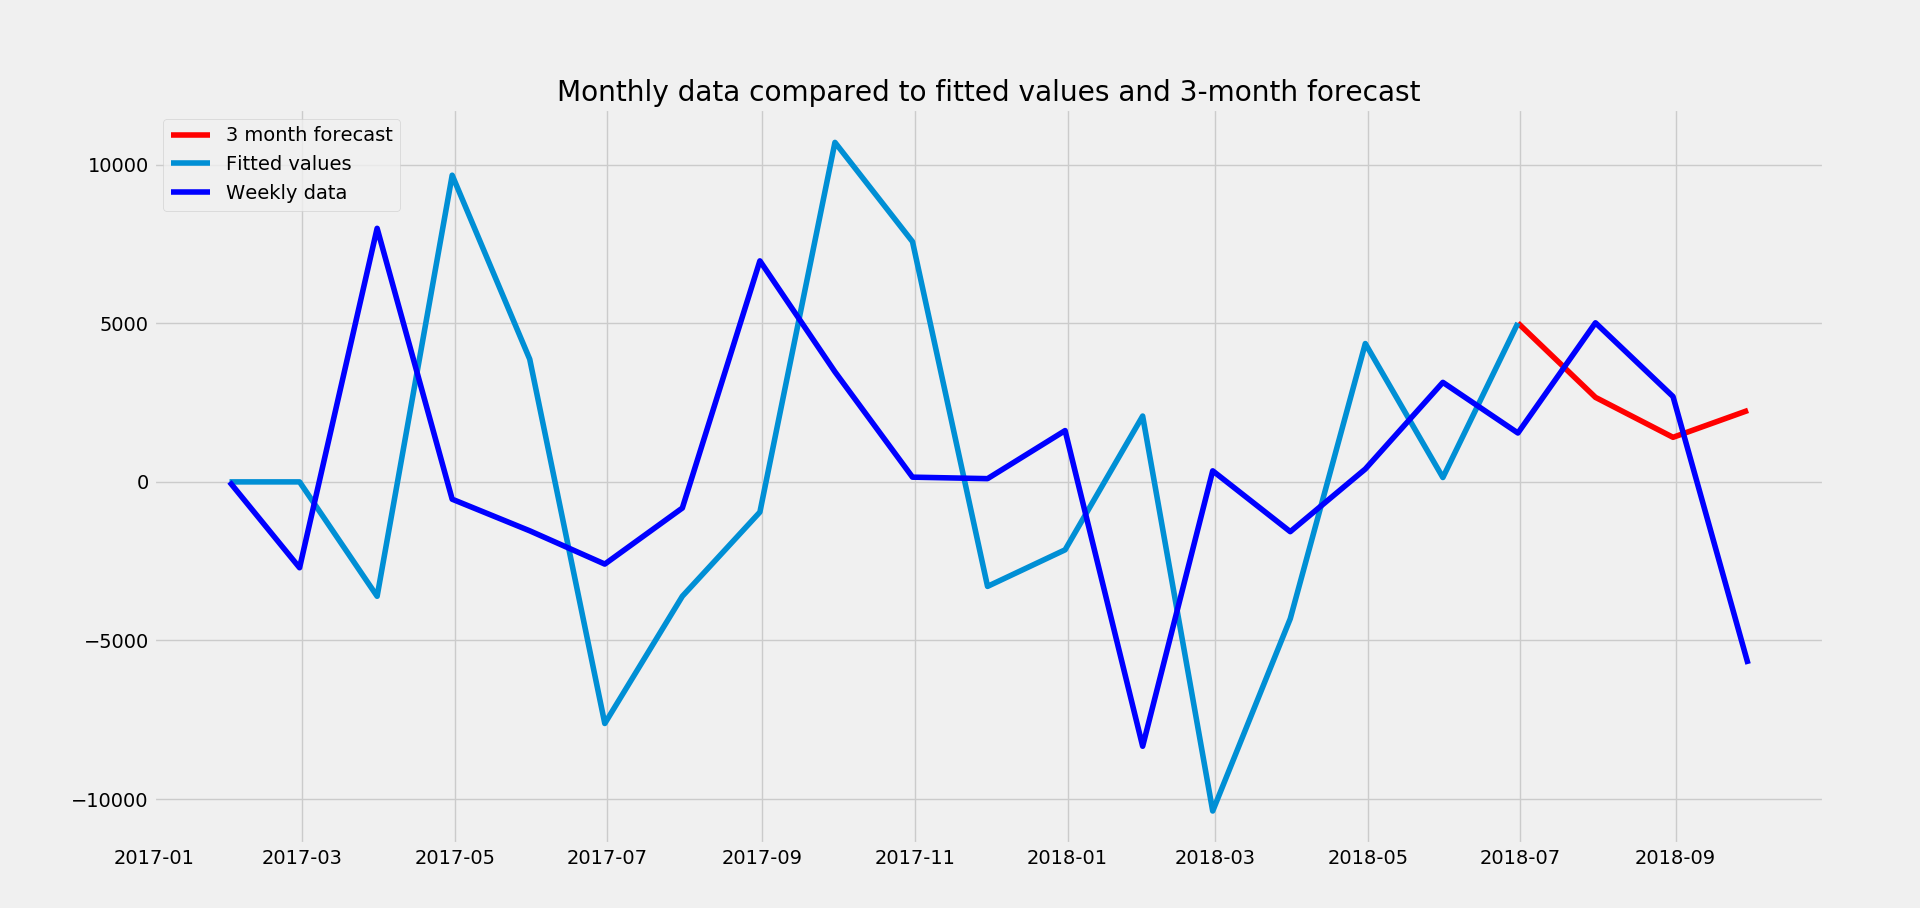

In [27]:
Image("images/3_month.png")

# LSTM Model 

Although Spyros Makridakis et. al (2018) found that long short-term memory (LSTM) performed quite poorly in comparison to other machine learning models in their study, this was restricted to only one-step forecasts. Since a multi-step forecast was needed for this project, LSTMs were chosen as a first initial pass for a machine learning model due to their ability to learn nonlinearities from the data. However, as we have very few data points (81 points for the weekly difference in shipping cost, and only 21 in the monthly difference in shipping cost), applying the LSTM and any further models is restricted to the weekly difference forecast. <br>
LSTMs are a subset of recurrent neural network (RNN) that are capable of learning long-term dependencies. They are highly skilled at preserving error that can be backpropagated through time. They contain information outside of the normal flow of the neural network in a gated cell, where information can be stored, written to or read from a cell. Due to the small size of the dataset used here, only one layer was used but other hyperparameters were tuned to improve the model's accuracy. Additionally, the LSTM model was then further developed by incorporating multiple layers and investigating whether this could improve performance. <br> <br> 
To begin with, the model had to be created and tuned to determine the best possible basic parameters before proceeding to investigating more complex parameters such as weight initialization, learning rate and network topology (number of neurons and layers). This is done below. <br> <br>
The data was also transformed by using a MinMax Scaler to scale it to the bounds of (-1,1) for both the training and test set, as these are the bounds for the hyperbolic tangent function. This is used instead of the sigmoid gating function in the LSTM model as it overcomes the vanishing gradient problem; it often converges faster than the sigmoid function in practice and its gradient computation is also less expensive.


In [57]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [32]:
def ts_to_supervised(data,lag=1):
    """
    Creates dataframe of lagged values.
    
    Inputs:
        data (pd.Series): time series
        lag (int, default=1): lag value
    
    Outputs:
        df (pd.DataFrame): dataframe of original series
                           and lagged values
    """
    df = pd.DataFrame(data)
    shifted = pd.Series(np.roll(data, lag), index=data.index)
    df = pd.concat([df,shifted],axis=1)
    df.drop(df.index[0],inplace=True)
    df.columns = ['Original','Shifted']
    return df

def scale(train, test):
    """
    Normalizes test and training data to (-1,1).
    
    Inputs:
        train (pd.Series): series of training data
        test (pd.Series): series of test data
        
    Outputs:
        scaler (sklearn.preprocessing.data.MinMaxScaler): Scaler object
        train_scaled (np.array): 2-D array of scaled training data 
        test_scaled (np.array): 2-D array of scaled test data
    """
    train = train.values
    test = test.values    
    # Fit the scaler
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    # Transform train (reshape just in case)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # Transform test (reshape just in case)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    """
    Inverts transformed data back to pre-scaled.
    
    Inputs:
        scaler (sklearn.preprocessing.data.MinMaxScaler): Scaler object used to scale
        X (np.array): 1-D array representing one data point of the scaled dataset
        yhat (np.array): 1-d array representing one predicted data point
        
    Outputs:
        inverted[0,-1] (np.array): 1-D array representing predicted value
    """
    new_row = [x for x in X] + [yhat]
    arr = np.array(new_row)
    arr = arr.reshape(1, len(arr))
    inverted = scaler.inverse_transform(arr)
    return inverted[0,-1]

def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    """
    Evaluates model on dataset and returns RMSE in original scale units.
    
    Inputs:
        model (keras.engine.sequential.Sequential): LSTM model used
        raw_data (np.array): 1-D array of raw data
        scaled_dataset (np.array): 2-D array of scaled and trimmed test/train values
        offset (int): 0
        batch_size (int): batch size used for prediction
        
    Outputs:
        rmse (np.float): RMSE score of prediction 
    """
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # reshape
    reshaped = X.reshape(len(X), 1, 1)
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = []
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = np.sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse

def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    """
    Fits LSTM model to training data whilst changing basic parameters.
    
    Inputs:
        train (np.array): 2-D array of scaled and trimmed training data
        test (np.array): 2-D array of scaled and trimmed test data
        raw (np.array): 1-D array of raw data
        scaler (sklearn.preprocessing.data.MinMaxScaler): Scaler object used to scale
        batch_size (int): batch size used for prediction
        nb_epoch (int): number of epochs used for training model
        neurons (int): number of neurons
        
    Outputs:
        history (pd.DataFrame): DataFrame of train and test RMSE scores
    """
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = [], []
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        model.reset_states()
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        model.reset_states()
    history = pd.DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

def test_harness(repeats, train, test, raw, scaler, batch_size, nb_epoch, neurons):
    """
    Shows plot of RMSE over training repeats for LSTM model.
    
    Inputs:
        repeats (int): number of times the model should learn on the training data
        train (np.array): 2-D array of scaled and trimmed training data
        test (np.array): 2-D array of scaled and trimmed test data
        raw (np.array): 1-D array of raw data
        scaler (sklearn.preprocessing.data.MinMaxScaler): Scaler object used to scale
        batch_size (int): batch size used for prediction
        nb_epoch (int): number of epochs used for training model
        neurons (int): number of neurons
        
    Outputs:
        plot (matplotlib.pyplot): plot of training and test scores over epochs and repeats
        history: test and train RMSE scores over repeats
    """
    for i in range(repeats):
        history = fit_lstm(train_trimmed, test_trimmed, raw_values, 
                           scaler, n_batch, n_epochs, n_neurons)
        plt.plot(history['train'], color='blue')
        plt.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], 
             history['test'].iloc[-1]))
    all_histories.append(history)
    plt.show()


We will first have a look at doing a first-pass with a batch size of 4, 1 neuron and 500 epochs.

0) TrainRMSE=2334.607843, TestRMSE=1708.032653
1) TrainRMSE=2337.943808, TestRMSE=1724.507364
2) TrainRMSE=2340.524312, TestRMSE=1681.567062
3) TrainRMSE=2351.259133, TestRMSE=1734.091040
4) TrainRMSE=2358.063221, TestRMSE=1751.937282
5) TrainRMSE=2342.482514, TestRMSE=1745.968944
6) TrainRMSE=2325.742968, TestRMSE=1749.893546
7) TrainRMSE=2340.126541, TestRMSE=1794.183522
8) TrainRMSE=2353.959359, TestRMSE=1720.178048
9) TrainRMSE=2340.997177, TestRMSE=1735.244964


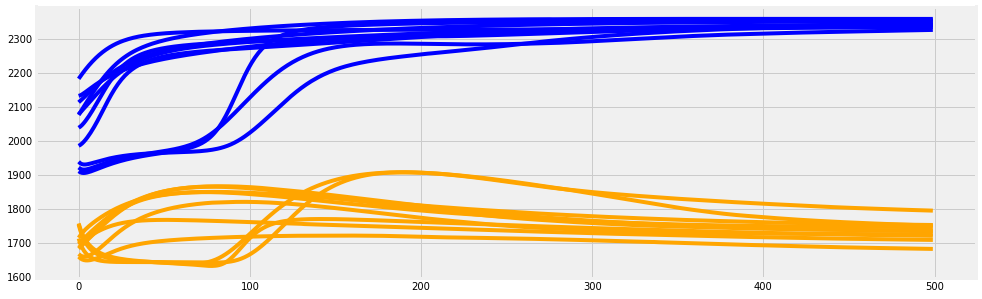

In [33]:
# Append all histories for future reference
all_histories = []

# Original dataset
raw_values = week_diff.values

# Transform to supervised learning problem
supervised = ts_to_supervised(week_diff, 1)

# Split into test and train
# BATCH SIZE OF 4
train_data = supervised.loc[:'2018-06-24']
test_data  = supervised.loc['2018-07-01':]

# Transform scale of data    
scaler, train_scaled, test_scaled = scale(train_data, test_data)   

# Trim data so that batch size is a common factor
train_trimmed = train_scaled
test_trimmed = test_scaled[2:, :]

# Parameters
repeats = 10
n_batch = 2
n_epochs = 500
n_neurons = 1

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

As can be seen above, our training RMSE scores are much larger than our test RMSE scores so we could see that our model was not, at least, overfitting. However, the current parameters are such that the best test RMSE score is only slightly below the Naive score and instead of gradually decreasing the RMSE over the epochs, there is a sharp initial inflection where both train and test RMSE converge to a value. <br>
Additional parameter changes were explored: first altering the number of epochs, then batch size and finally number of neurons. These changes are all shown and the qualitative observations are summarised further below.

0) TrainRMSE=2369.140697, TestRMSE=1742.431858
1) TrainRMSE=2351.668391, TestRMSE=1738.640335
2) TrainRMSE=2353.057761, TestRMSE=1754.830732
3) TrainRMSE=2359.856715, TestRMSE=1712.558030
4) TrainRMSE=2349.416362, TestRMSE=1725.499012
5) TrainRMSE=2356.832973, TestRMSE=1728.549712
6) TrainRMSE=2354.775241, TestRMSE=1726.564747
7) TrainRMSE=2350.384725, TestRMSE=1759.811941
8) TrainRMSE=2353.037754, TestRMSE=1772.185167
9) TrainRMSE=2351.244304, TestRMSE=1731.109442


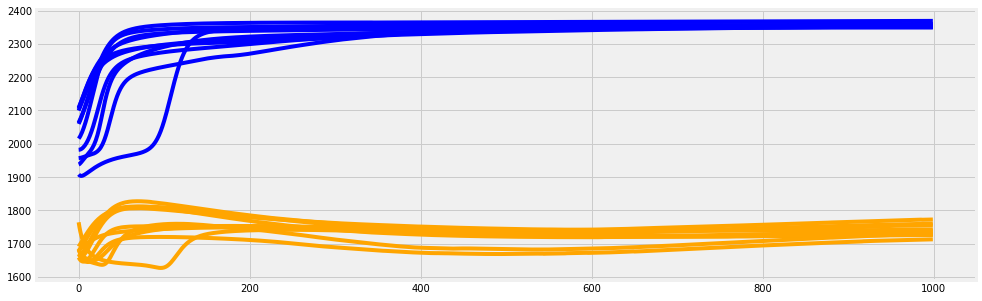

In [34]:
# CHANGING NUMBER OF EPOCHS TO 1000

# Parameters
repeats = 10
n_batch = 2
n_epochs = 1000 # Increased from 500
n_neurons = 1

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

0) TrainRMSE=1902.561751, TestRMSE=1684.178174
1) TrainRMSE=1888.949844, TestRMSE=1713.968490
2) TrainRMSE=1923.906507, TestRMSE=1708.272953
3) TrainRMSE=1904.902962, TestRMSE=1708.443914
4) TrainRMSE=1907.201672, TestRMSE=1690.173582
5) TrainRMSE=1889.575367, TestRMSE=1687.784295
6) TrainRMSE=1927.132016, TestRMSE=1686.565479
7) TrainRMSE=1894.634796, TestRMSE=1673.292934
8) TrainRMSE=1866.135687, TestRMSE=1757.491738
9) TrainRMSE=1883.795931, TestRMSE=1679.813246


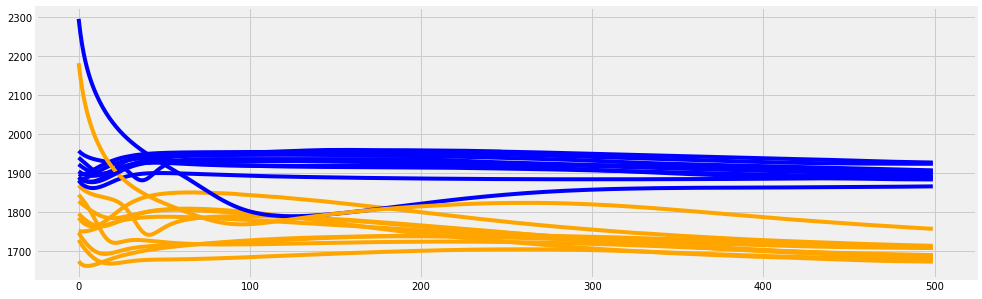

In [35]:
# CHANGING BATCH SIZE TO 2

# Do not need to trim for batch size of 2
train_trimmed = train_scaled
test_trimmed = test_scaled

repeats = 10
n_batch = 2 # Halved the batch size
n_epochs = 500
n_neurons = 1

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

0) TrainRMSE=2337.137967, TestRMSE=2272.450998
1) TrainRMSE=2391.051341, TestRMSE=2389.388556
2) TrainRMSE=2345.532501, TestRMSE=2319.130702
3) TrainRMSE=2358.240867, TestRMSE=2356.696555
4) TrainRMSE=2336.627742, TestRMSE=2280.105905
5) TrainRMSE=2355.680136, TestRMSE=2336.039446
6) TrainRMSE=2349.521651, TestRMSE=2338.186549
7) TrainRMSE=2340.030123, TestRMSE=2363.153631
8) TrainRMSE=2376.088782, TestRMSE=2341.716254
9) TrainRMSE=2406.483272, TestRMSE=2371.459543


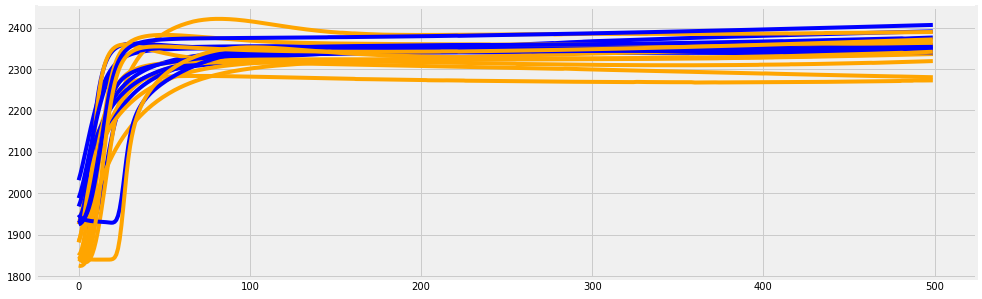

In [36]:
# CHANGING BATCH SIZE TO 1

repeats = 10
n_batch = 1 # Batch size of 1
n_epochs = 500
n_neurons = 1

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

0) TrainRMSE=1748.748293, TestRMSE=1659.601171
1) TrainRMSE=1696.020207, TestRMSE=1711.169868
2) TrainRMSE=1780.120202, TestRMSE=1656.784139
3) TrainRMSE=1700.666071, TestRMSE=1705.688969
4) TrainRMSE=1696.742534, TestRMSE=1645.086367
5) TrainRMSE=1716.749763, TestRMSE=1511.196156
6) TrainRMSE=1847.301873, TestRMSE=1604.952909
7) TrainRMSE=1886.422373, TestRMSE=1605.462994
8) TrainRMSE=1792.468236, TestRMSE=1629.234872
9) TrainRMSE=1848.534574, TestRMSE=1632.133930


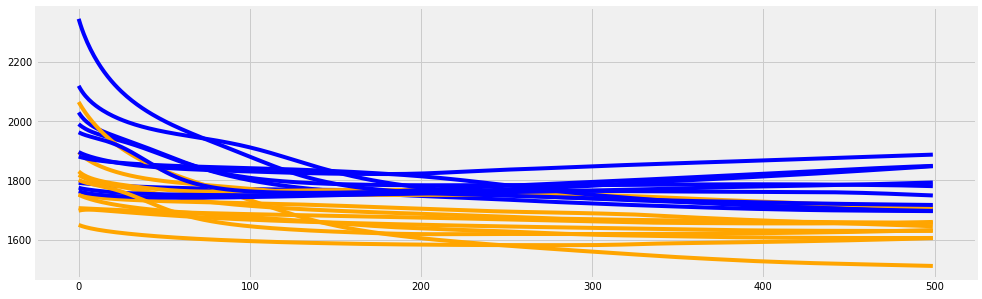

In [38]:
# CHANGING BATCH SIZE to 5

# Adding extra sample from training set to dataset to make 80%/20% split (75 weeks/15 weeks)
train_data = supervised.loc[:'2018-06-17']
test_data  = supervised.loc['2018-06-24':]

# Transform scale of data    
scaler, train_scaled, test_scaled = scale(train_data, test_data)    

train_trimmed = train_scaled
test_trimmed = test_scaled

repeats = 10
n_batch = 5 # Batch size of 5
n_epochs = 500
n_neurons = 1

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

0) TrainRMSE=1713.550674, TestRMSE=1480.065017
1) TrainRMSE=1826.859899, TestRMSE=1605.448417
2) TrainRMSE=1783.988521, TestRMSE=1668.949147
3) TrainRMSE=1851.596404, TestRMSE=1688.018432
4) TrainRMSE=1738.153462, TestRMSE=1667.298091
5) TrainRMSE=1883.867101, TestRMSE=1597.336250
6) TrainRMSE=1816.508049, TestRMSE=1614.329204
7) TrainRMSE=1732.990145, TestRMSE=1566.659201
8) TrainRMSE=1848.673421, TestRMSE=1626.794028
9) TrainRMSE=1761.181276, TestRMSE=1551.767067


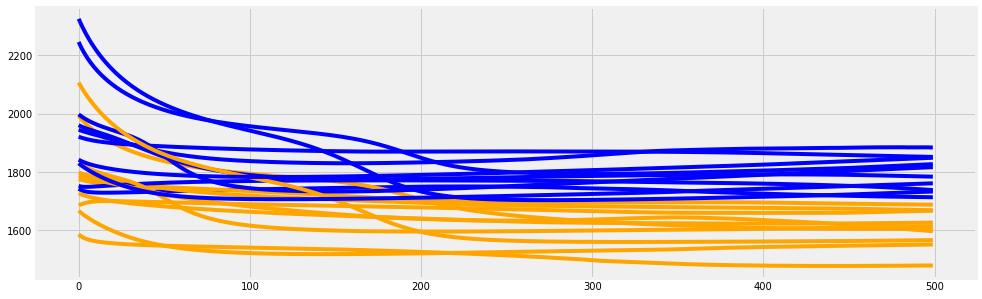

In [39]:
# CHANGING BATCH SIZE TO 15 (Highest common factor)

repeats = 10
n_batch = 5 # Batch size of 5
n_epochs = 500
n_neurons = 1

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

0) TrainRMSE=1752.741401, TestRMSE=1564.934645
1) TrainRMSE=1729.277028, TestRMSE=1676.556282
2) TrainRMSE=1721.562892, TestRMSE=1533.018614
3) TrainRMSE=1693.688589, TestRMSE=1578.300347
4) TrainRMSE=1711.734334, TestRMSE=1525.622646
5) TrainRMSE=1661.376616, TestRMSE=1523.189072
6) TrainRMSE=1714.682127, TestRMSE=1611.874606
7) TrainRMSE=1707.982545, TestRMSE=1586.894256
8) TrainRMSE=1712.325311, TestRMSE=1615.758625
9) TrainRMSE=1689.199022, TestRMSE=1555.781252


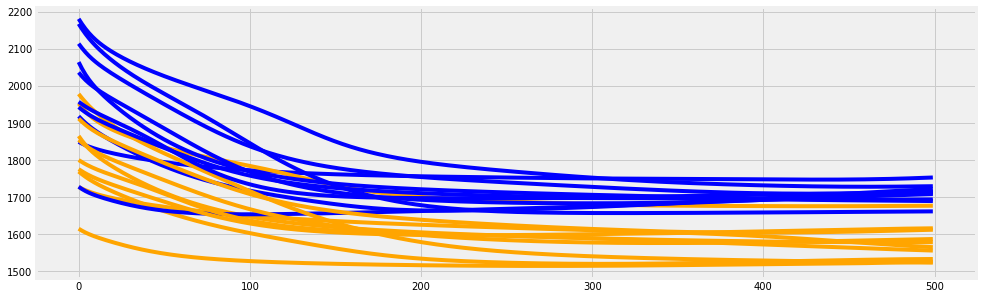

In [40]:
# CHANGING NUMBER OF NEURONS TO 2

repeats = 10
n_batch = 15 # Batch size of 15
n_epochs = 500
n_neurons = 2 # 2 neurons

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

0) TrainRMSE=1718.432399, TestRMSE=1595.506620
1) TrainRMSE=1718.495581, TestRMSE=1590.054424
2) TrainRMSE=1737.318480, TestRMSE=1558.276184
3) TrainRMSE=1699.405572, TestRMSE=1534.685900
4) TrainRMSE=1773.716578, TestRMSE=1567.319973
5) TrainRMSE=1674.625425, TestRMSE=1590.890347
6) TrainRMSE=1836.634319, TestRMSE=1496.562870
7) TrainRMSE=1768.986580, TestRMSE=1559.507354
8) TrainRMSE=1767.026494, TestRMSE=1567.454711
9) TrainRMSE=1719.388874, TestRMSE=1672.803287


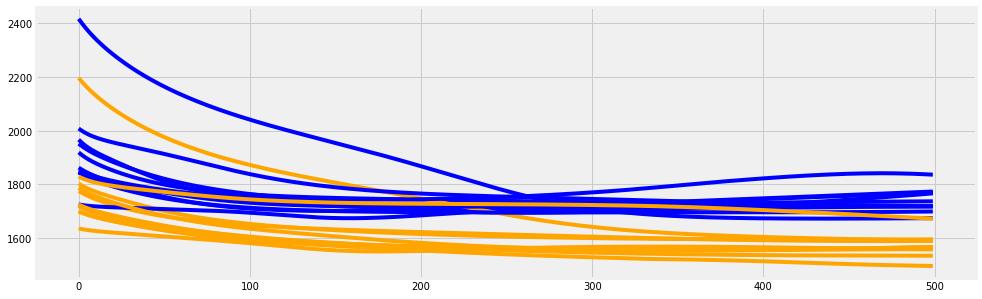

In [41]:
# CHANGING NUMBER OF NEURONS TO 3

repeats = 10
n_batch = 15 # Batch size of 15
n_epochs = 500
n_neurons = 2 # 3 neurons

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

From the above experimentation with the hyperparameters, the following observations could be made: <br>
* Small batch numbers produce a poorer model fit, where the RMSE increases over epochs or fluctuates and experiences inflections; 
* Higher batch numbers produce better model fits where the model fits best and slowly converges to a lower RMSE for the epochs for both test and training sets, without signs of overfitting. For a batch size of 5 and 15, the test RMSE scores and training RMSE scores are not significantly far apart and asymptote smoothly;
* Increasing number of epochs from 500 to 1000 for a batch size of 4 makes little difference to RMSE scores as the model appears to have fitted and converged at 500 epochs already;
* 2 neurons appears to be the optimal number, as the test and training RMSE scores are closely clustered together and do not fluctuate over epochs. 
<br>
As such, the most optimal hyperparameters appeared to be a batch size of 15 and with 2 neurons. The number of epochs was increased again to 1000 for this selection of parameters to check if the model was sufficiently trained or if the RMSE could further decrease with further training. The results are shown below.

0) TrainRMSE=1796.226628, TestRMSE=1659.712847
1) TrainRMSE=1748.555430, TestRMSE=1576.131213
2) TrainRMSE=1736.817351, TestRMSE=1575.842928
3) TrainRMSE=1817.031554, TestRMSE=1691.179607
4) TrainRMSE=1759.333894, TestRMSE=1528.507881
5) TrainRMSE=1738.071115, TestRMSE=1525.753913
6) TrainRMSE=1908.358078, TestRMSE=1575.253194
7) TrainRMSE=1756.068985, TestRMSE=1527.705138
8) TrainRMSE=1775.969492, TestRMSE=1596.869456
9) TrainRMSE=1746.956662, TestRMSE=1589.413157


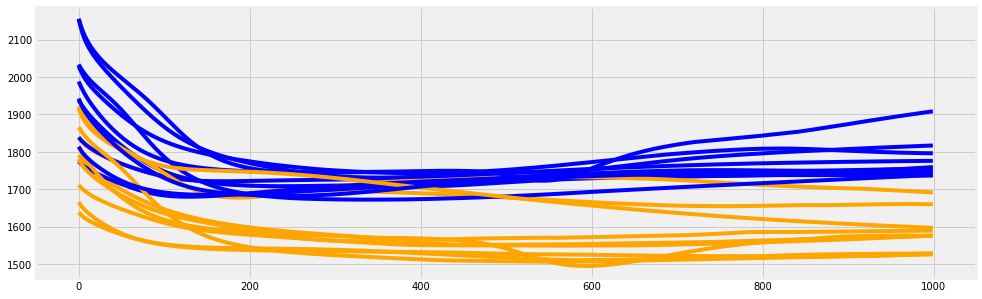

In [42]:
# 2 NEURONS, BATCH OF 15, 1000 EPOCHS

repeats = 10
n_batch = 15 # Batch size of 15
n_epochs = 1000 # 1000 epochs
n_neurons = 2 # 2 neurons

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

It could be seen that the sweet-spot occurred at between 350-450 epochs as RMSE then began to increase with further training, so early stopping was preferable here at approximately 400 epochs. At this point, the model was deemed skilful as a naive forecast has a RMSE score of 1900 and performed better than SARIMA in terms of RMSE, but still more poorly than Prophet. The actual forecast is shown below where the evaluate function has been modified to output prediction instead of RMSE.

In [46]:
def get_prediction(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    """
    Modified form of evaluate() to return scaled prediction.
    
    Inputs:
        model (keras.engine.sequential.Sequential): LSTM model used
        raw_data (np.array): 1-D array of raw data
        scaled_dataset (np.array): 2-D array of scaled and trimmed test/train values
        offset (int): 0
        batch_size (int): batch size used for prediction
        
    Outputs:
        predictions (np.array): array of scaled forecast
    """
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # reshape
    reshaped = X.reshape(len(X), 1, 1)
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = []
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = np.sqrt(mean_squared_error(raw_data[1:], predictions))
    return predictions

def predictions(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    """
    Modified form of fit_LSTM() to return prediction on final epoch.
    
    Inputs:
        train (np.array): 2-D array of scaled and trimmed training data
        test (np.array): 2-D array of scaled and trimmed test data
        raw (np.array): 1-D array of raw data
        scaler (sklearn.preprocessing.data.MinMaxScaler): Scaler object used to scale
        batch_size (int): batch size used for prediction
        nb_epoch (int): number of epochs used for training model
        neurons (int): number of neurons
        
    Outputs:
        history (pd.DataFrame): DataFrame of train and test RMSE scores
        test_predict (np.array): array of scaled forecast
        train_predict (np.array): array of scaled model fit to training data
        
    """
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = [], []
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        if i == nb_epoch-1:
            train_predict = get_prediction(model, raw_train, train, scaler, 0, batch_size)
        model.reset_states()
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        if i == nb_epoch-1:
            test_predict = get_prediction(model, raw_test, test, scaler, 0, batch_size)
        model.reset_states()
    history = pd.DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history, train_predict, test_predict


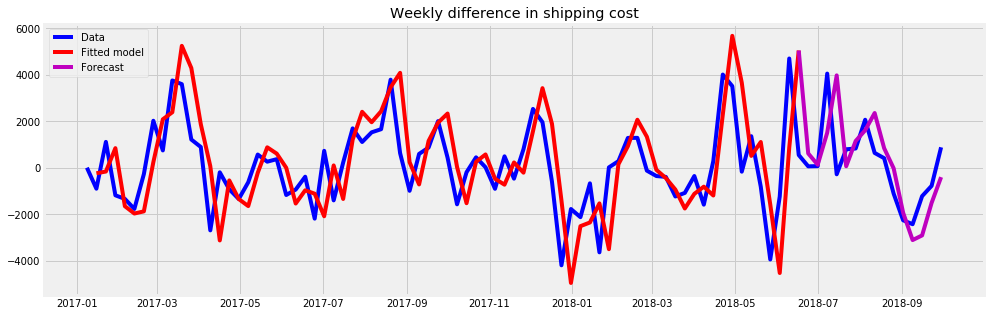

RMSE score = 1699.220550, MAE score = 1123.787086


In [61]:
# RMSEs, train_predict, test_predict = predictions(train_trimmed, test_trimmed, raw_values, scaler, n_batch, n_epochs, n_neurons)

train_data = supervised.loc[:'2018-06-17']
test_data  = supervised.loc['2018-06-24':]

train_model = pd.Series(train_predict, index=train_data.index)
test_model = pd.Series(test_predict, index=test_data.index)
all_model = train_model.append(test_model)
test_model_plot = all_model.loc['2018-06-17':]

plt.plot(week_diff, 'b', label = 'Data')
plt.plot(train_model, 'r', label = 'Fitted model')
plt.plot(test_model_plot, 'm', label = 'Forecast')
plt.legend(loc='upper left')
plt.title('Weekly difference in shipping cost')
plt.show()

RMSE_overall = np.sqrt(mean_squared_error(week_diff.iloc[1:].values, all_model.values))
MAE_forecast = mean_absolute_error(week_diff.loc['2018-06-24':].values, test_model.values)
print('RMSE score = %f, MAE score = %f' % (RMSE_overall, MAE_forecast))

It can be seen that although the overall RMSE is lower than both the SARIMA and Prophet forecasts, qualitatively it could be seen that the LSTM model was performing far better in terms of capturing the volatility of the data. The mean absolute error score was also much lower than for the SARIMA forecast and extremely close to the Prophet MAE, and was only 2% higher. This machine learning model clearly performed much better for such irregular, volatile data.<br><br>
To investigate whether this could be further improved by refining the LSTM model, the network topology was modified by adding more layers and modifying the number of neurons.

## Adding layers

Additional layers were added to the LSTM to investigate the effect of modifying the network topology. Additionally, regularisation was incorporated by probabilistically excluding input and recurrent connections to LSTM units from activation and weight updates while training. The number of neurons as well as the dropout rate were the primary hyperparameters of interest and which were modified.<br>
This network was far more computationally expensive and it was necessary to investigate whether the additional expense was made up for by better performance.

In [70]:
from keras.layers import Activation
from keras.layers import Dropout

dropout = 0.25
optimizer = "adam" 
activ_func = 'tanh'
loss = 'mean_squared_error'

multi_layered_hist = []

def build_model(inputs, output_size, neurons, dropout, batch_size, activ_func=activ_func, 
                loss=loss, optimizer=optimizer):
    """
    Builds the more complex three-layered LSTM model.
    """
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model

def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    """
    Fits LSTM model to training data whilst changing basic parameters.
    
    Inputs:
        train (np.array): 2-D array of scaled and trimmed training data
        test (np.array): 2-D array of scaled and trimmed test data
        raw (np.array): 1-D array of raw data
        scaler (sklearn.preprocessing.data.MinMaxScaler): Scaler object used to scale
        batch_size (int): batch size used for prediction
        nb_epoch (int): number of epochs used for training model
        neurons (int): number of neurons
        
    Outputs:
        history (pd.DataFrame): DataFrame of train and test RMSE scores
    """
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = build_model(X, output_size=1, neurons=neurons, dropout=dropout, batch_size=batch_size, activ_func=activ_func, 
                        loss=loss, optimizer=optimizer, )
    # fit model
    train_rmse, test_rmse = [], []
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        model.reset_states()
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        model.reset_states()
    history = pd.DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 1, 2)              32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2)              0         
_________________________________________________________________
lstm_96 (LSTM)               (None, 1, 2)              40        
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 2)              0         
_________________________________________________________________
lstm_97 (LSTM)               (None, 2)                 40        
_________________________________________________________________
dropout_3 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 3         
__________

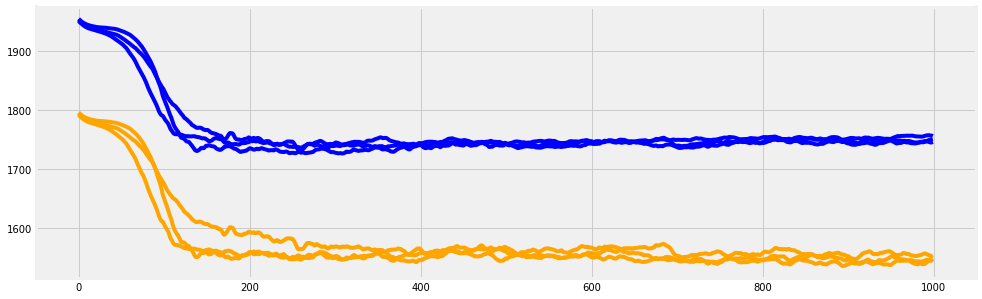

In [67]:
# Initial test of modified topology

repeats = 3 # Lower number of repeats while tweaking model
n_batch = 15 # Batch size of 15
n_epochs = 1000 # 1000 epochs
n_neurons = 2 # 2 neurons

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch,
             n_epochs, n_neurons)

From initial inspection, it did not appear that the updated model is performing notably better than the original LSTM model and the very miniscule improvement in performance certainly did not justify the additional computational cost. Dropout rate and the number of neurons were altered to determine whether this could bring about an improvement in performance and produce a more skilful model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (None, 1, 40)             6720      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 40)             0         
_________________________________________________________________
lstm_105 (LSTM)              (None, 1, 40)             12960     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 40)             0         
_________________________________________________________________
lstm_106 (LSTM)              (None, 40)                12960     
_________________________________________________________________
dropout_12 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 41        
__________

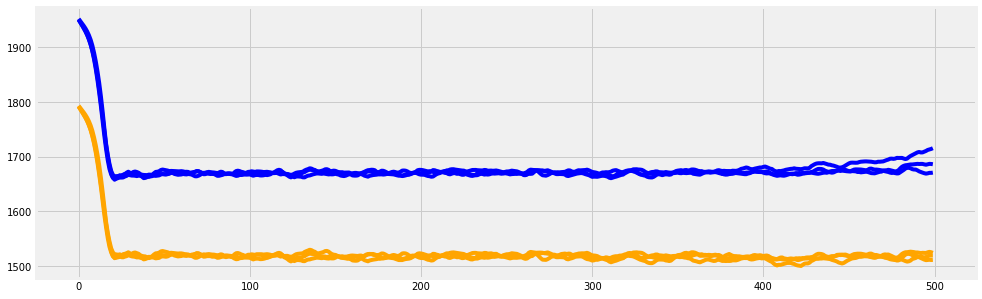

In [68]:
# Lowering number of epochs and increasing number of neurons

repeats = 3 # Lower number of repeats while tweaking model
n_batch = 15 # Batch size of 15
n_epochs = 500 # 1000 epochs - lowered number of epochs
n_neurons = 40 # 42 neurons - large increase in number of neurons

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch,
             n_epochs, n_neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_113 (LSTM)              (None, 1, 150)            91200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 150)            0         
_________________________________________________________________
lstm_114 (LSTM)              (None, 1, 150)            180600    
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 150)            0         
_________________________________________________________________
lstm_115 (LSTM)              (None, 150)               180600    
_________________________________________________________________
dropout_21 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 151       
__________

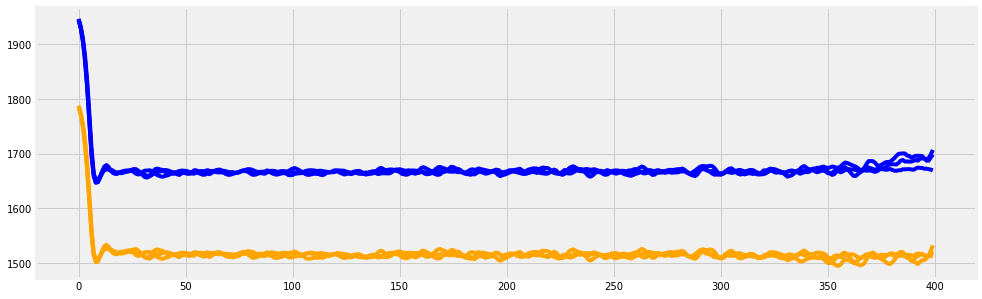

In [71]:
# Further increasing number of neurons and lowering number of epochs

repeats = 3 # Lower number of repeats while tweaking model
n_batch = 15 # Batch size of 15
n_epochs = 400 # 1000 epochs - lowered number of epochs
n_neurons = 150 # 42 neurons - large increase in number of neurons

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch,
             n_epochs, n_neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_122 (LSTM)              (None, 1, 40)             6720      
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 40)             0         
_________________________________________________________________
lstm_123 (LSTM)              (None, 1, 40)             12960     
_________________________________________________________________
dropout_29 (Dropout)         (None, 1, 40)             0         
_________________________________________________________________
lstm_124 (LSTM)              (None, 40)                12960     
_________________________________________________________________
dropout_30 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 41        
__________

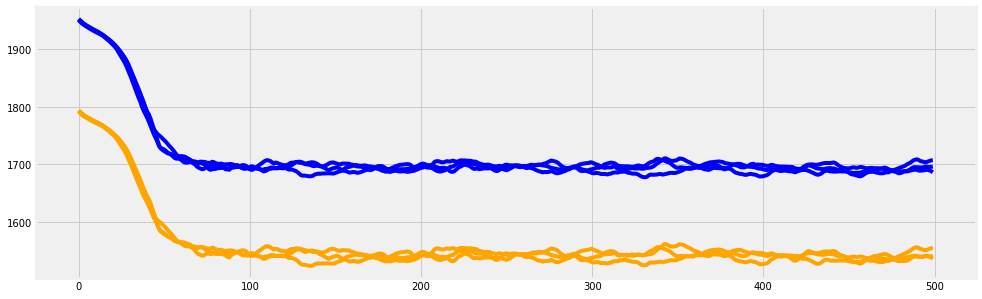

In [72]:
# Changing dropout rate to 0.75

dropout = 0.75
repeats = 3 # Lower number of repeats while tweaking model
n_batch = 15 # Batch size of 15
n_epochs = 500 # 1000 epochs - lowered number of epochs
n_neurons = 40 # 42 neurons - large increase in number of neurons

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch,
             n_epochs, n_neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 1, 40)             6720      
_________________________________________________________________
dropout_37 (Dropout)         (None, 1, 40)             0         
_________________________________________________________________
lstm_132 (LSTM)              (None, 1, 40)             12960     
_________________________________________________________________
dropout_38 (Dropout)         (None, 1, 40)             0         
_________________________________________________________________
lstm_133 (LSTM)              (None, 40)                12960     
_________________________________________________________________
dropout_39 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 41        
__________

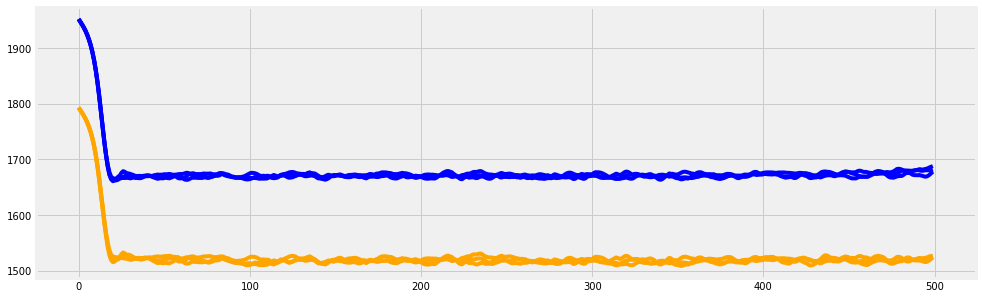

In [73]:
# Changing dropout rate to 0.25

dropout = 0.25
repeats = 3 # Lower number of repeats while tweaking model
n_batch = 15 # Batch size of 15
n_epochs = 500 # 1000 epochs - lowered number of epochs
n_neurons = 40 # 42 neurons - large increase in number of neurons

test_harness(repeats, train_trimmed, test_trimmed, raw_values, scaler, n_batch,
             n_epochs, n_neurons)

It could be seen that adding additional complexity and layers to the LSTM model only very marginally improved the skill of the model and did not make up for the much heavier computational cost. As such, the original LSTM model that was previously used to produce the forecast was deemed more skilful and appropriate for forecasting.

In [69]:
table_dict_2 = [{'MAE':1097.519, 'RMSE':1273.675},
              {'MAE':1429.011, 'RMSE':1665.672},
              {'MAE':1123.79, 'RMSE':1699.22},
              {'RMSE':1909.117},
              {'MAE':5465.381, 'RMSE':3098.294},
              {'MAE':6336.858, 'RMSE':3877.488},
              {'RMSE':6185.076}]

table = pd.DataFrame(table_dict_2)
table_t = table.transpose()
table_t.columns = ['Prophet weekly', 'SARIMA weekly', 'LSTM weekly', 'Naive weekly', 'Prophet monthly', 'SARIMA monthly', 
                   'Naive monthly']
table_t

,Prophet weekly,SARIMA weekly,LSTM weekly,Naive weekly,Prophet monthly,SARIMA monthly,Naive monthly
MAE,1097.519,1429.011,1123.79,NaN,5465.381,6336.858,NaN
RMSE,1273.675,1665.672,1699.22,1909.117,3098.294,3877.488,6185.076


# Findings

Although it was expected that the classical time series forecasting methods would outperform the machine learning model, it was in fact found that the LSTM ML method performed the best. Although the Prophet model technically had the lowest MAE and RMSE scores, the MAE of the LSTM for the forecast was only 3% higher than for the Prophet forecast, and visually it could be seen to capture the volatility of the data much better.<br><br>
However, the monthly prediction was not investigated for the LSTM due to the small size of the dataset that would render it inappropriate for a deep learner. In terms of monthly forecasts, the Prophet model performed better than SARIMA but both performed extremely poorly with very large error. Although they would be considered skilful as their RMSE was lower than the Naive forecast, qualitatively the results can be seen to be not useful. <br><br>
All three models could be seen to be skilful, however, as all outperformed the Naive forecast. The recommended forecasting model studied here is the LSTM model, but there are many recommendations to be made in achieving better results for these predictions and are discussed below.

# Recommendations

For future work and extension in forecasting these time series, there are several recommendations that have been made--these involve the quality/quantity of the original data, possible alternate models to be used and refinements to the current models. The recommendations pertaining to the data include:
* To improve forecasting performance, another year of shipping cost data should be provided. This would especially allow for more accurate predictions of difference of monthly shipping cost average. Furthermore, the ML models would have a larger training dataset and the classical models could be further refined as seasonality and trends in the data would be more clear. 
* A summary of subject matter expertise (SME) regarding particular events that may influence the shipping costs would be useful, so as to incorporate these events into the forecasting models. No information has been provided regarding the given datasets and an understanding of the factors that influence shipping costs could greatly improve performance.
<br><br>Recommendations for improving the current models include:<br>
* Layering the SARIMA model with a GARCH model, used to forecast volatility. The SARIMA forecast is skilful in terms of its RMSE score but fails to capture the large variance of the data, so modifying the forecast to be based on SARIMA-GARCH could improve this.
* Including more fourier terms in the SARIMA forecast to better model seasonality on all levels (yearly, quarterly, etc.) would allow for a more accurate representation of the periodicity of the data. This would be very powerful if combined with SME knowledge of seasonality influencing the shipping costs.
* Improving deep learning performance by changing the weight initialisation scheme and creating a custom learning rate schedule.
* Building an ensemble model by incorporating a convolutional neural network into the LSTM model to create a CNN-LSTM or a Conv-LSTM.
* Investigating forecasting the original daily data and then averaging and taking the difference to obtain the weekly and monthly difference in average forecasts. This could prove to be a good workaround for the monthly forecast, despite not having much data to train the model on.
<br><br> Recommendations for investigating other methods and models include:
* Using a TBATS model, which is a state space model based on exponential smoothing, for the advantage of capturing multiple seasonalities. This class of model works particularly well for high frequency seasonality.
* Investigating multi-layer perceptron (MLP) and bayesian neural networks (BNN) as Spyros Makridakis et. al (2018) found that these were the highest performing ML models for time series forecasting.